## Unsupervised Anomaly Detection for Property Valuations

In this Jupyter notebook, we present an end-to-end workflow for detecting potential fraud cases in property valuations using unsupervised machine learning techniques. Leveraging a robust dataset from New York City, our approach focuses on identifying anomalies that could signify fraudulent activity or data errors.

## Workflow:

Data Cleaning: The initial steps focus on cleansing the data, including handling exclusions and imputing missing values.

## Feature Engineering: We craft features tailored to highlight unusual property valuations – the primary indicators of potential anomalies.

## Dimensionality Reduction:
To handle the high correlation among variables and reduce dimensionality, we employ PCA (Principal Component Analysis).
Before applying PCA, we standardize the data (z-scaling) to ensure features have equal weight.
After retaining the top principal components, we again standardize the data. This step, while optional, ensures that each principal component contributes equally to the subsequent analysis.
	
## Anomaly Detection:

Method 1 - Minkowski Distance: By examining the distance from the origin in the scaled PC space, we can identify potential outliers.

Method 2 - Autoencoder: A neural network-based approach where the fraud score is determined by the reproduction error of an autoencoder model. This method captures intricate, non-linear patterns that might be indicative of fraud.
Though each method can stand alone as an efficient fraud detection mechanism, for robustness, we merge their outcomes.
	
## Score Aggregation and Ranking:
To integrate insights from both anomaly detection techniques, we average their scores. For this, we rank-order the scores from each method and then compute their mean. This consolidated score offers a holistic view of potential anomalies.

## Investigative Analysis:

With properties ranked by the likelihood of anomaly, we delve into the top-ranking records.
To aid the analysis, we utilize a heatmap showing variable z-scores, highlighting the features most contributing to a property's high anomaly score.


## Dataset:

The data used in this project is sourced from the official New York City portal, providing comprehensive property valuation and assessment details.
The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [94]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:00.013892


In [95]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 1.61 s, sys: 579 ms, total: 2.19 s
Wall time: 2.47 s


(1070994, 32)

In [96]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [97]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [98]:
#new_df = data.loc[data['RECORD'].isin(top_records_df['RECORD'])]


In [99]:
#new_df.to_excel('output.xlsx', index=False)


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [100]:
# first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [101]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [102]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [103]:
data.shape

(1070994, 32)

In [104]:
# this is how many records we removed
len(data) - len(property_data)

24478

In [105]:
numrecs = len(property_data)

## Fill in missing ZIP

In [106]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [107]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [108]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [109]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [110]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [111]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64


In [112]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [113]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [114]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 1.09 s, sys: 14.8 ms, total: 1.1 s
Wall time: 1.11 s


In [115]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [116]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43684

In [117]:
temp['TAXCLASS'].value_counts()

TAXCLASS
1B    19000
4     17768
2      3434
3      2398
1       877
2C      138
2B       34
2A       30
1A        5
Name: count, dtype: int64

In [118]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64


In [119]:
temp.head().transpose()

,0,1,59,60,61
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [120]:
len(property_data[property_data["STORIES"]==0])

0

In [121]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]
    
    
    

In [122]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [123]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [124]:
mean_LTFRONT

TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
Name: LTFRONT, dtype: float64

In [125]:
mean_LTDEPTH

TAXCLASS
1      99.278967
1A     90.095778
1B    104.046130
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.747557
3     273.994553
4     124.231567
Name: LTDEPTH, dtype: float64

In [126]:
mean_BLDFRONT

TAXCLASS
1     21.403236
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887866
3     10.000000
4     62.059559
Name: BLDFRONT, dtype: float64

In [127]:
mean_BLDDEPTH

TAXCLASS
1      41.560512
1A     44.952387
1B     82.666667
1C     60.094862
1D     36.862069
2     104.282570
2A     62.435640
2B     66.521339
2C     68.658517
3      17.500000
4      86.275049
Name: BLDDEPTH, dtype: float64

In [128]:
data = property_data.copy()
data.shape

(1046516, 32)

In [129]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [130]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [131]:
data.count()

RECORD      1046516
BBLE        1046516
BORO        1046516
BLOCK       1046516
LOT         1046516
EASEMENT       2762
OWNER       1014771
BLDGCL      1046516
TAXCLASS    1046516
LTFRONT     1046516
LTDEPTH     1046516
EXT          353364
STORIES     1046516
FULLVAL     1046516
AVLAND      1046516
AVTOT       1046516
EXLAND      1046516
EXTOT       1046516
EXCD1        625079
STADDR      1046053
ZIP         1046516
EXMPTCL       10467
BLDFRONT    1046516
BLDDEPTH    1046516
AVLAND2      267195
AVTOT2       267201
EXLAND2       82171
EXTOT2       119170
EXCD2         92912
PERIOD      1046516
YEAR        1046516
VALTYPE     1046516
zip3        1046516
dtype: int64

In [132]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [133]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [134]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [135]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [136]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [137]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [212]:
# # Calculate total acreage for each ZIP code
# acreage = data.groupby('ZIP').apply(lambda x: (x['LTFRONT'] * x['LTDEPTH']).sum())

# # Merge acreage back into original DataFrame
# data = data.merge(acreage.rename('TOTALACREAGE'), on='ZIP')


In [46]:
# # Calculate average lot size for each ZIP and TAXCLASS group
# avg_lot_size = data.groupby(['ZIP', 'TAXCLASS']).apply(lambda x: (x['LTFRONT'] * x['LTDEPTH']).mean())

# # Merge average lot size back into original DataFrame
# data = data.merge(avg_lot_size.rename('AVGLOTSIZE'), on=['ZIP', 'TAXCLASS'])

# # Calculate z-score of TOTALACREAGE using the average lot size for the same ZIP and TAXCLASS group
# #data['ACREAGE_ZSCORE'] = (data['TOTALACREAGE'] - data['AVGLOTSIZE']) / data.groupby(['ZIP', 'TAXCLASS'])['TOTALACREAGE'].std()


In [ ]:
import pandas as pd


# Calculate the total acreage for each property
data['total_acreage'] = data['LTFRONT'] * data['LTDEPTH'] 

# Group the data by ZIP code and calculate the median ratio of total value to total acreage
zip_median = data.groupby('ZIP').apply(lambda x: (x['AVTOT'] / x['total_acreage']).median())

# Calculate the ratio of total value to total acreage for each property
data['value_per_acre'] = data['AVTOT'] / data['total_acreage']

# Identify properties with ratios that are significantly higher or lower than the median for the area
data['unusual_value'] = data['ZIP'].apply(lambda x: data.loc[data['ZIP']==x, 'value_per_acre'] > zip_median.loc[x]).astype(int)


In [47]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r7inv_taxclass,0.068946,0.000049,0.007301,0.005052,0.002717
r8inv_taxclass,0.00086,0.000095,0.004664,0.003227,0.001736
r9inv_taxclass,0.000934,0.000103,0.045842,0.031735,0.017076
value_ratio,7.86698,6.462046,7.459903,7.459905,6.662788


In [48]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

In [49]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [50]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1046516, 56)

In [51]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,57777.406626,386.588395,558.693624,1038.804619
r2,3996.868587,36195.940760,736.761464,1064.760189,1979.757338
r3,724.395187,6560.176972,14.735229,21.295204,39.595147
r4,8.079350,4266.226465,62.337391,90.089449,94.815422
r5,789.194776,2672.672406,118.802810,171.692774,180.699549
r6,143.034199,484.396968,2.376056,3.433855,3.613991
r7,18.413002,25999.832982,173.964788,251.412180,467.462079
r8,1798.590864,16288.173342,331.542677,479.142178,890.890802
r9,325.977834,2952.079637,6.630854,9.582844,17.817816
r1inv,0.024433,0.000017,0.002587,0.001790,0.000963


In [52]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1046516.0,213.503808,528.509868,3.920017e-04,76.375353,152.916667,243.200000,1.356802e+05
r2,1046516.0,536.237504,1015.743970,7.470782e-04,212.235545,500.000000,683.891491,3.107425e+05
r3,1046516.0,243.931653,486.583927,8.983394e-05,82.741261,239.102564,336.257310,2.275000e+05
r4,1046516.0,10.453704,69.427805,8.333333e-06,2.356020,4.598000,7.225959,2.203231e+04
r5,1046516.0,22.710592,373.449262,2.096125e-04,6.215246,14.983333,20.287152,3.348421e+05
r6,1046516.0,9.972084,173.490209,1.038033e-05,2.021085,7.148054,10.043885,1.116140e+05
r7,1046516.0,26.785106,201.622470,8.333333e-06,5.284000,8.581667,13.528964,6.338662e+04
r8,1046516.0,50.329579,930.162498,3.062474e-04,17.478683,26.980501,36.003636,8.718980e+05
r9,1046516.0,18.980834,323.424616,6.049251e-05,7.100314,12.679808,17.575758,2.906327e+05
r1inv,1046516.0,0.081869,0.869733,7.370272e-06,0.004112,0.006539,0.013092,9.622785e+01


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:10: UserWarning: Boolean Series key will be reindexed to 

CPU times: user 13.4 s, sys: 11 s, total: 24.4 s
Wall time: 31 s


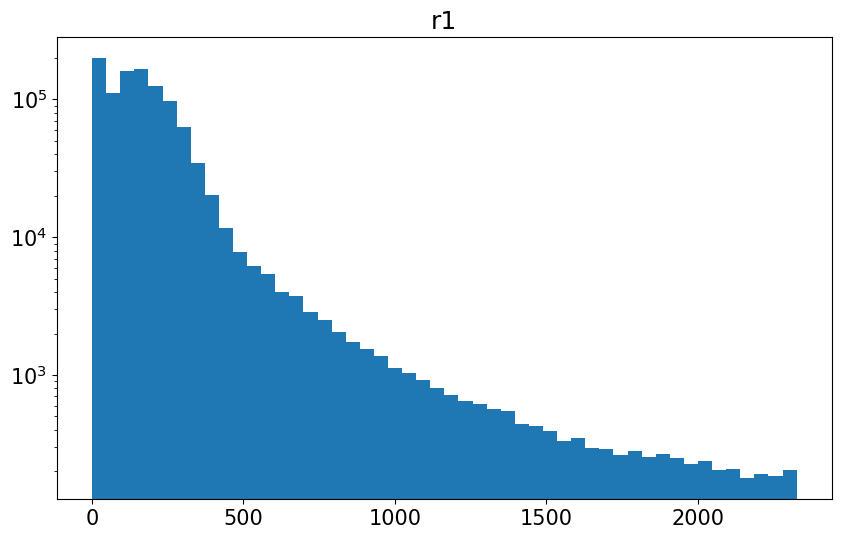

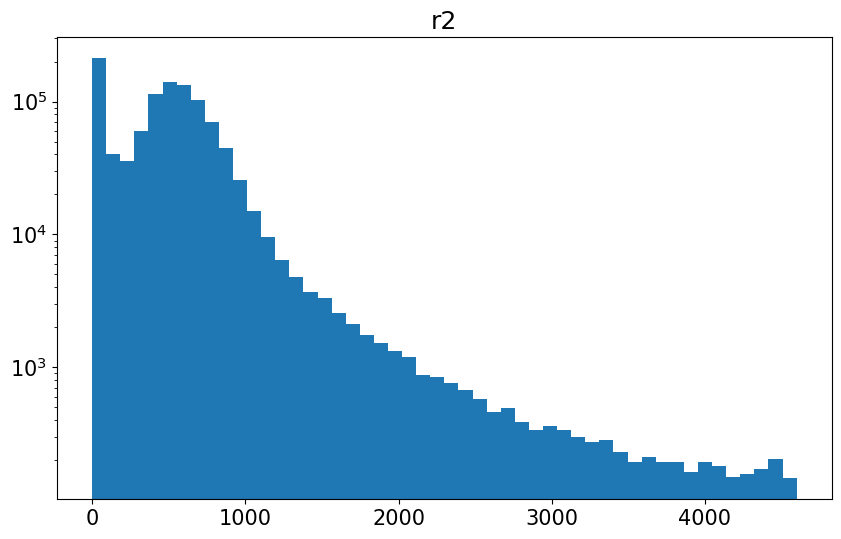

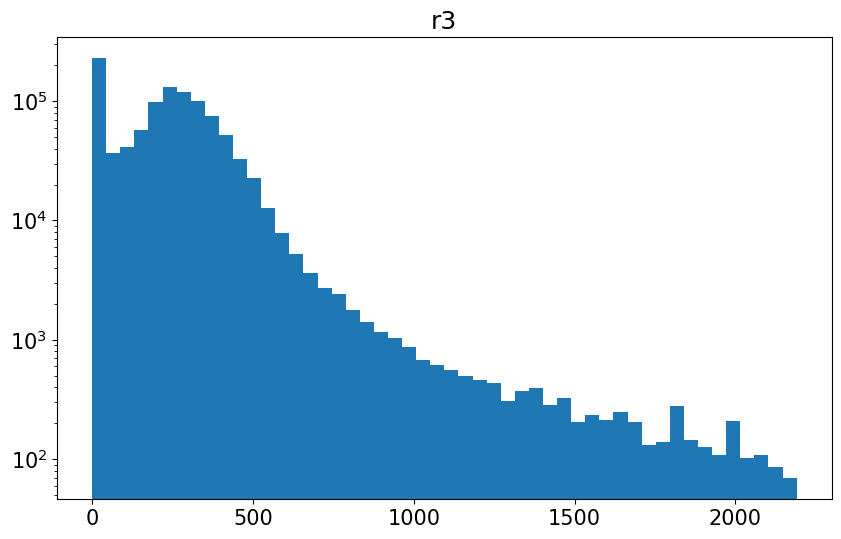

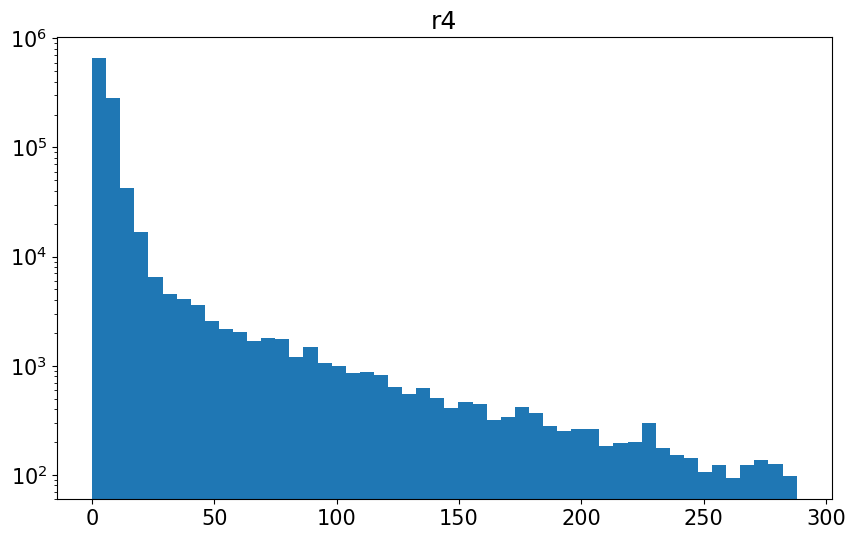

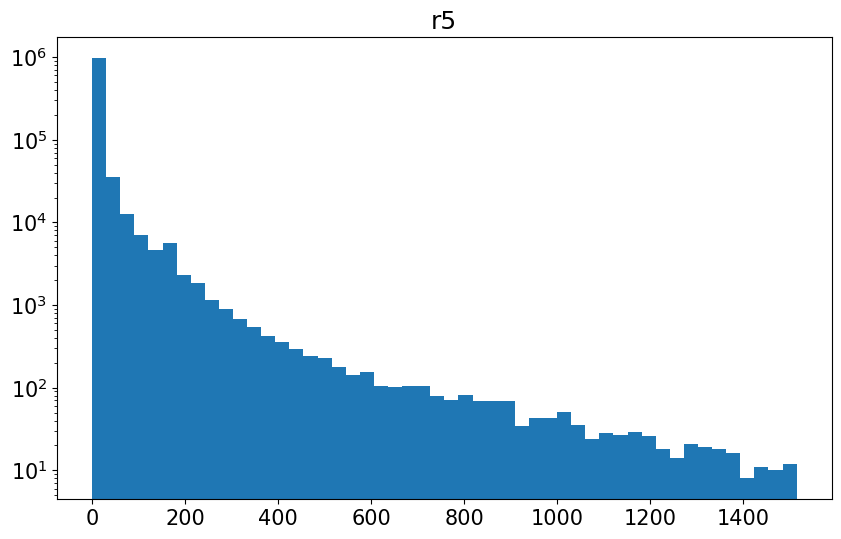

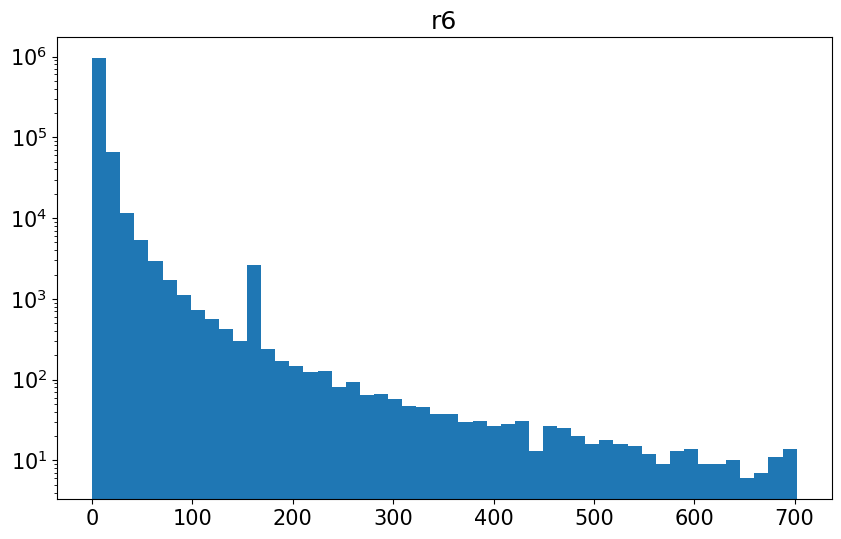

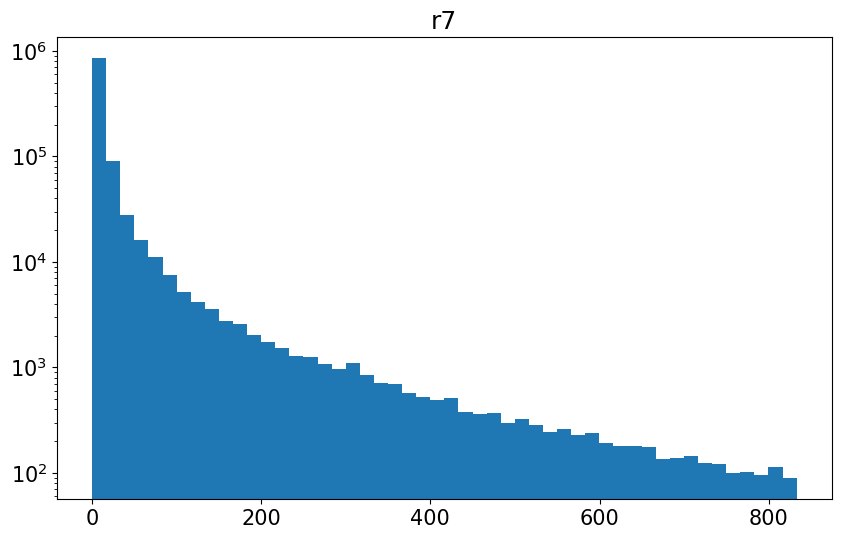

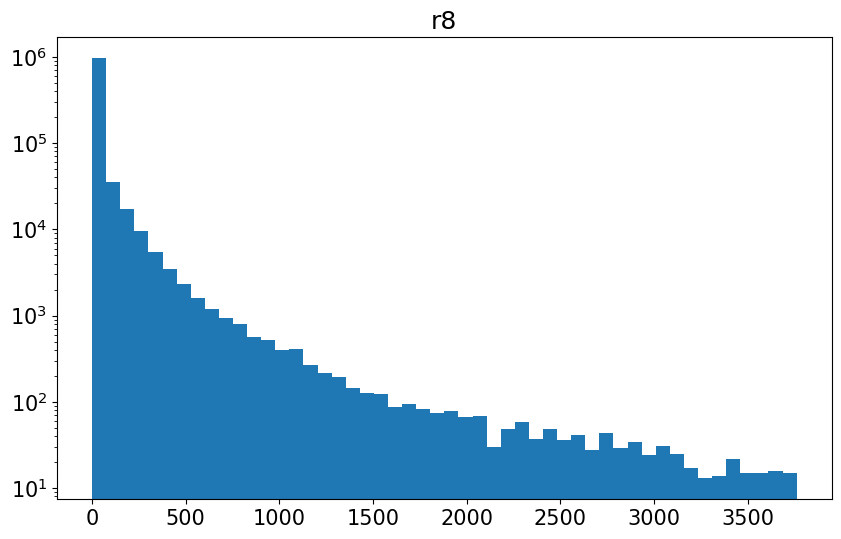

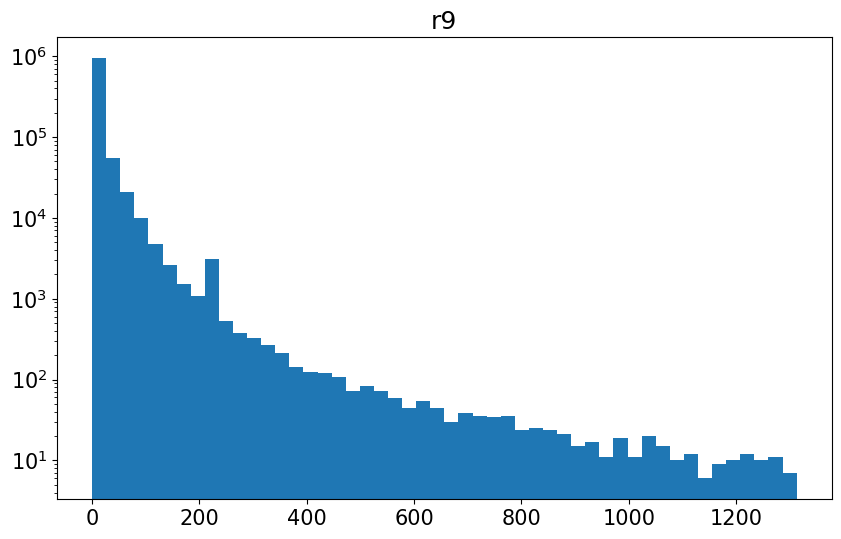

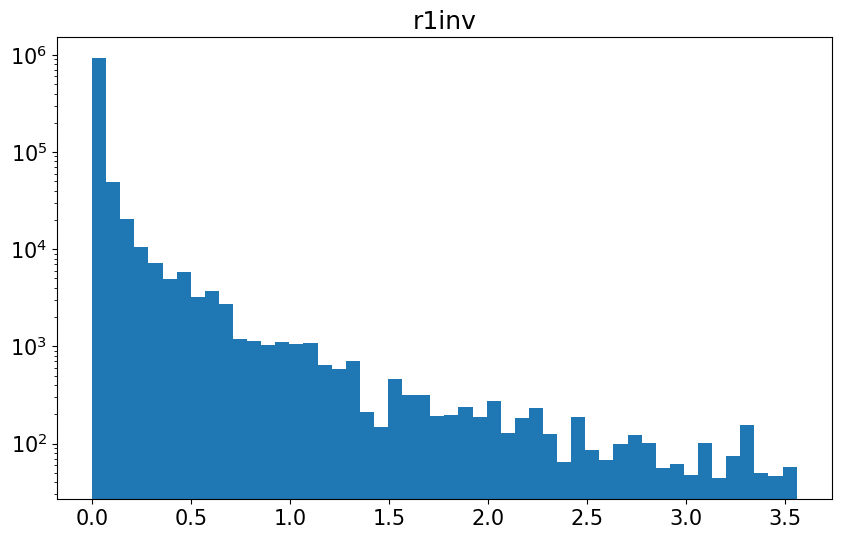

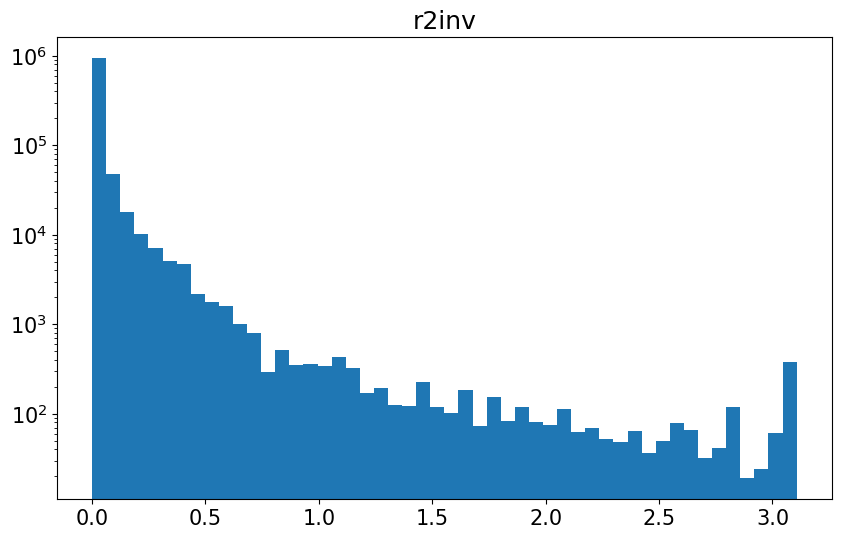

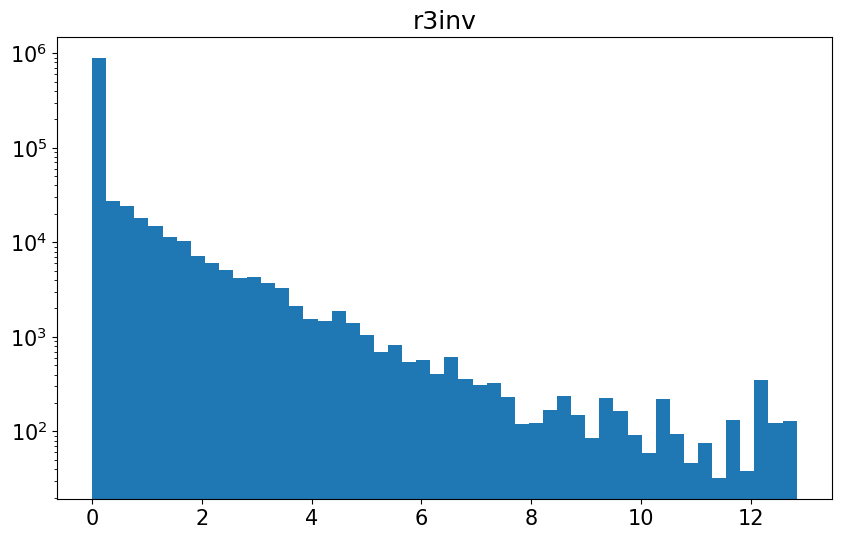

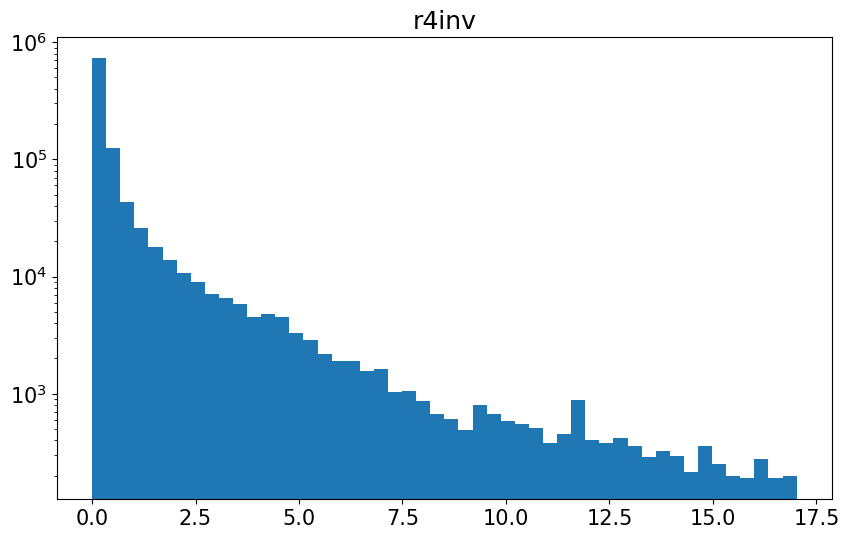

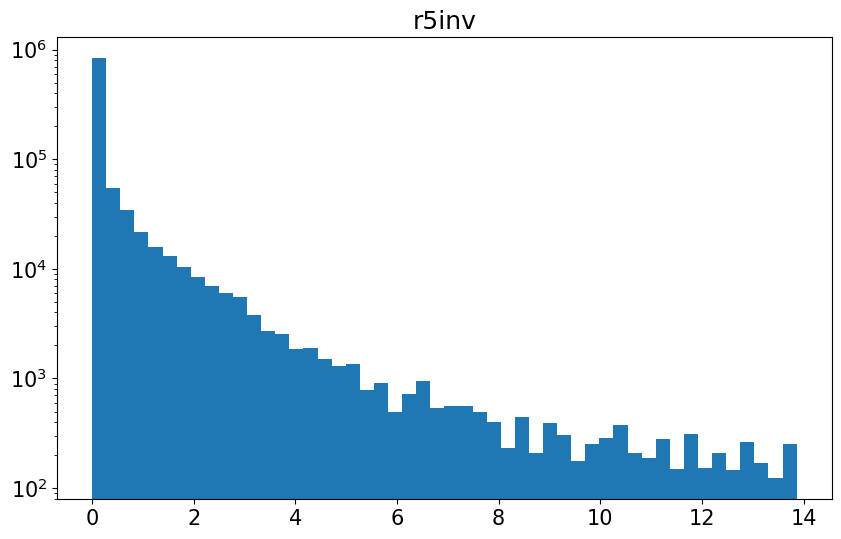

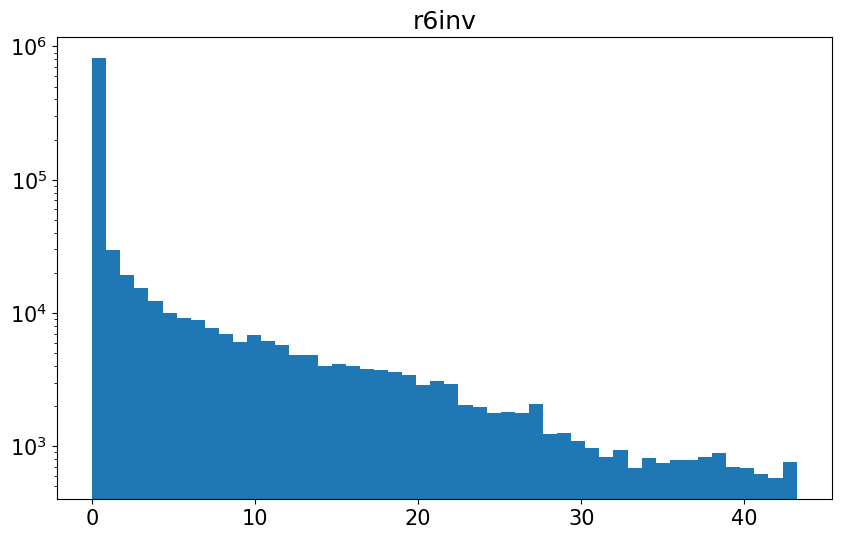

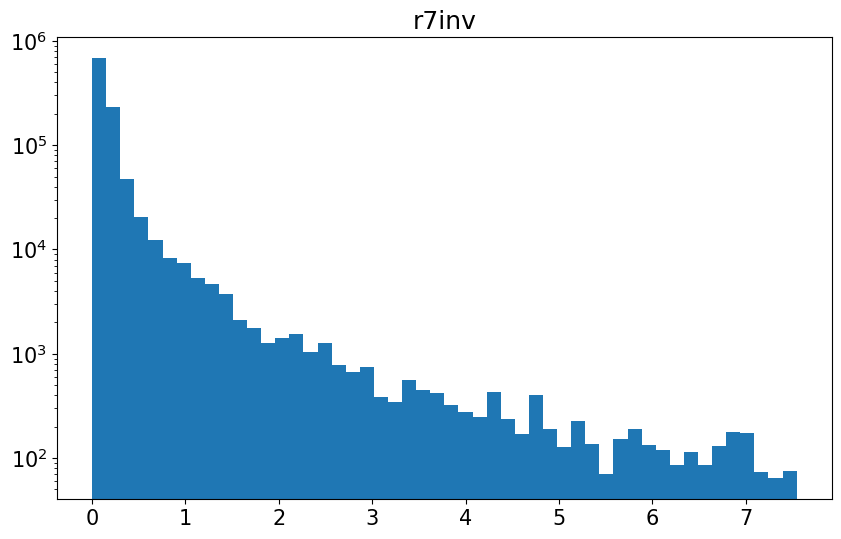

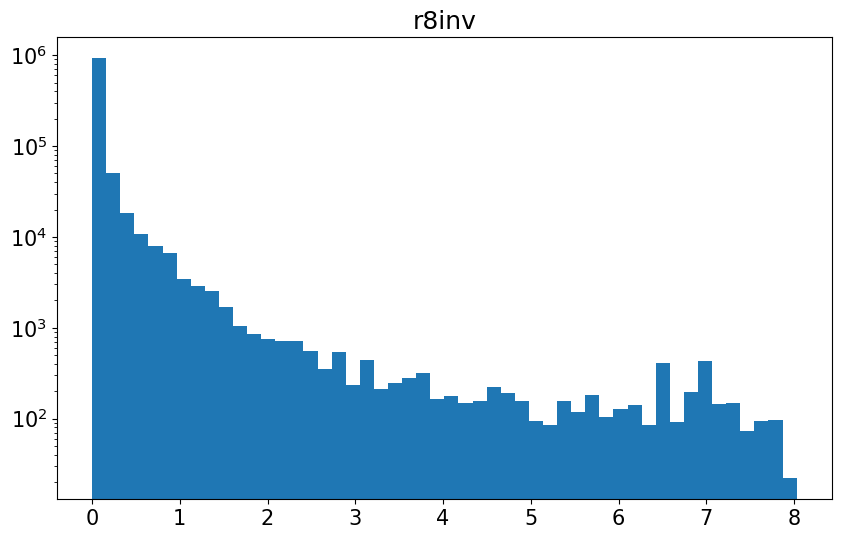

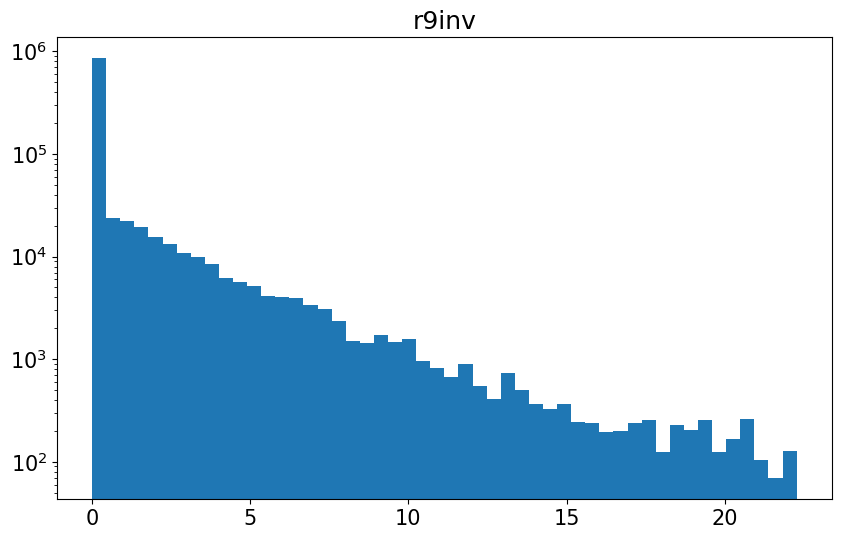

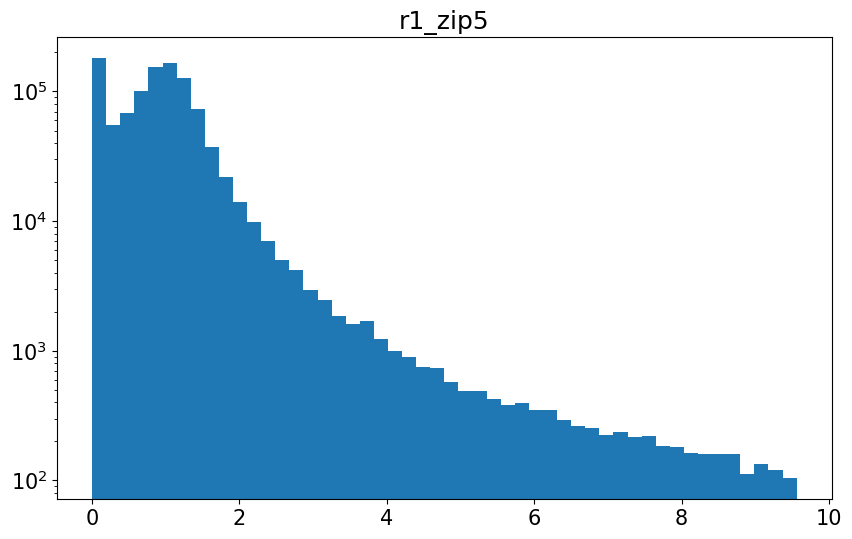

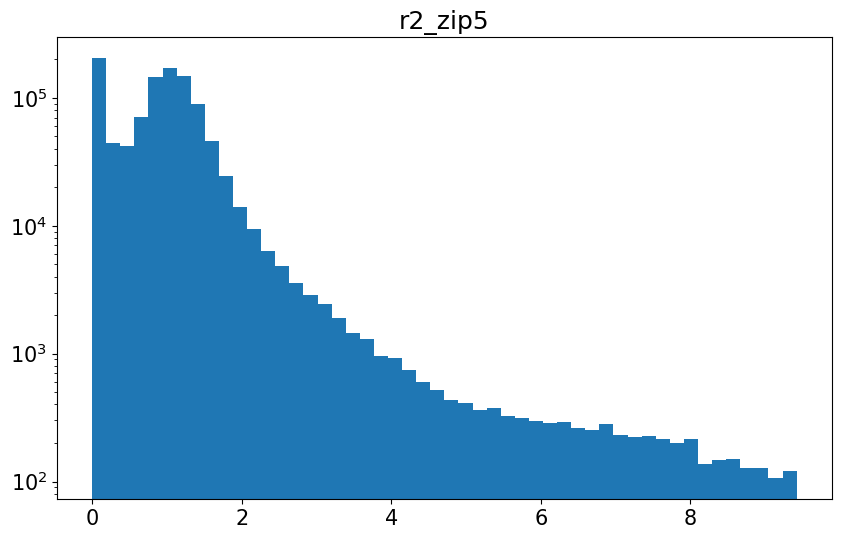

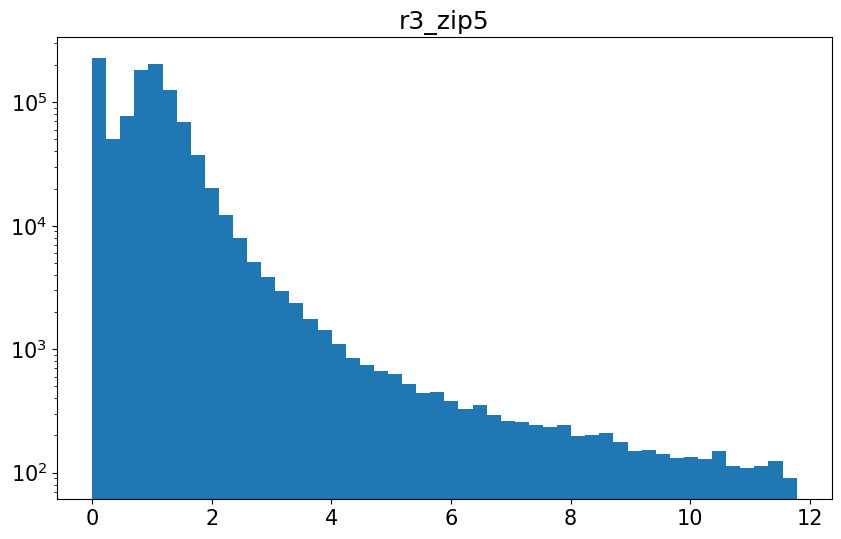

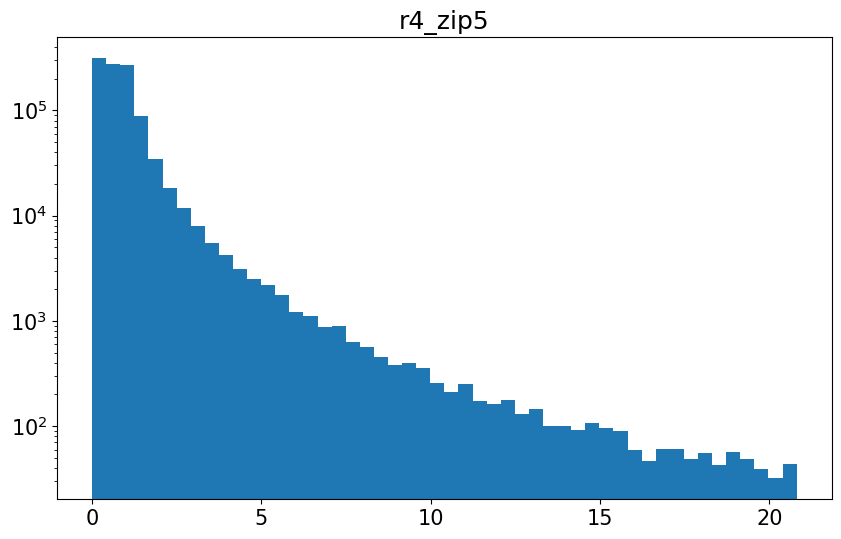

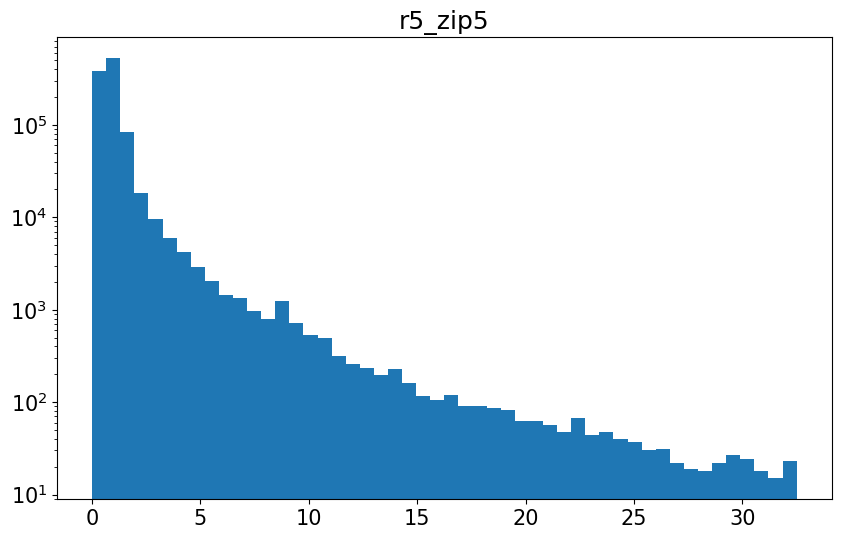

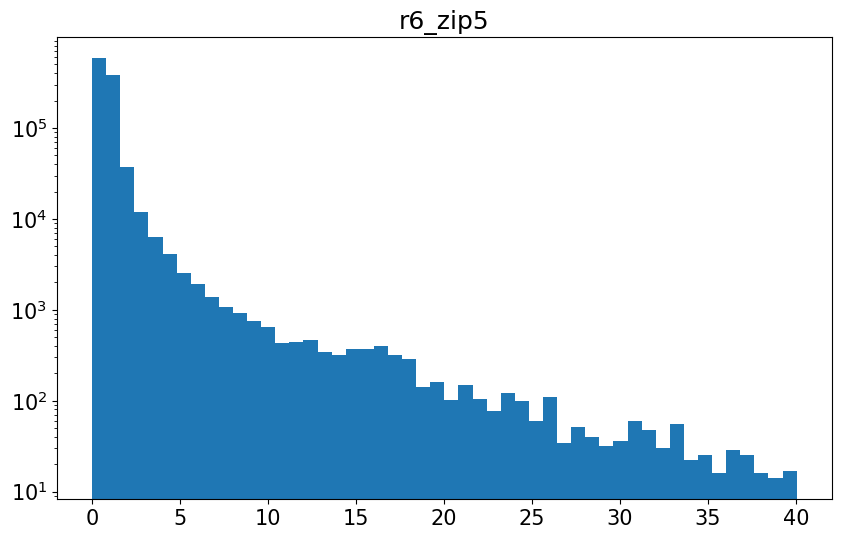

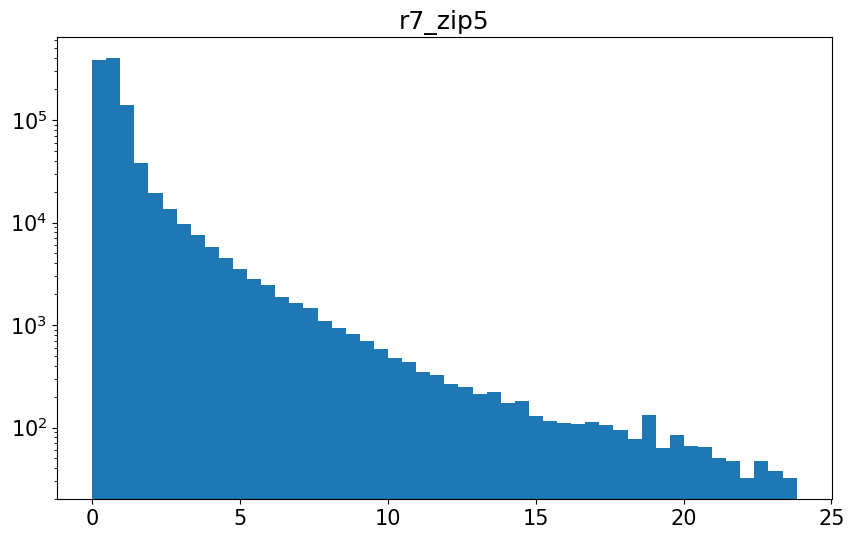

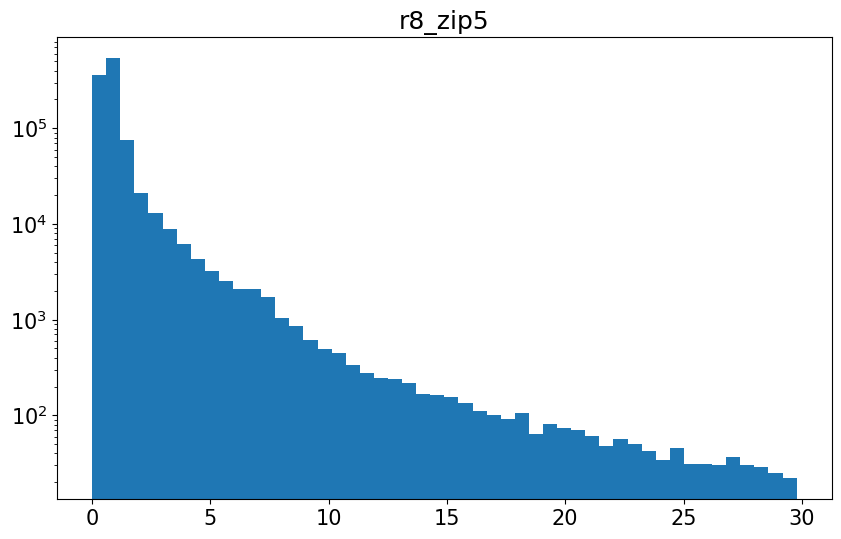

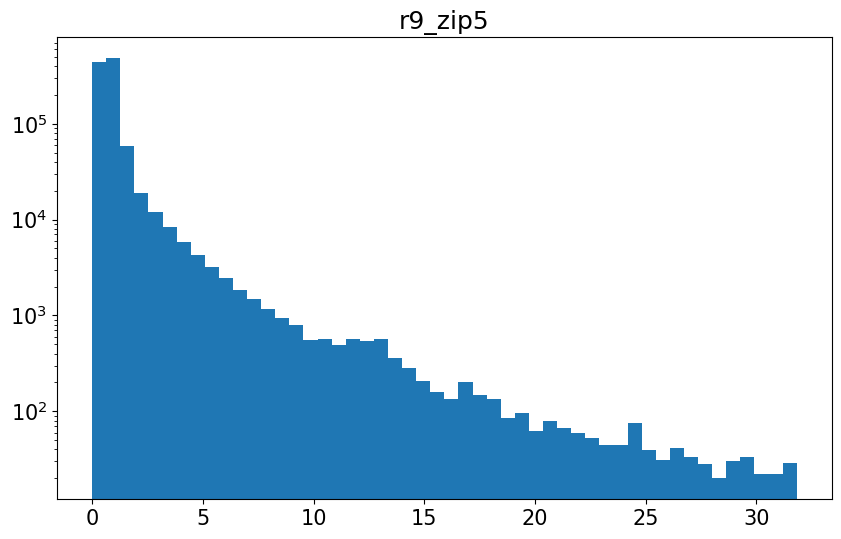

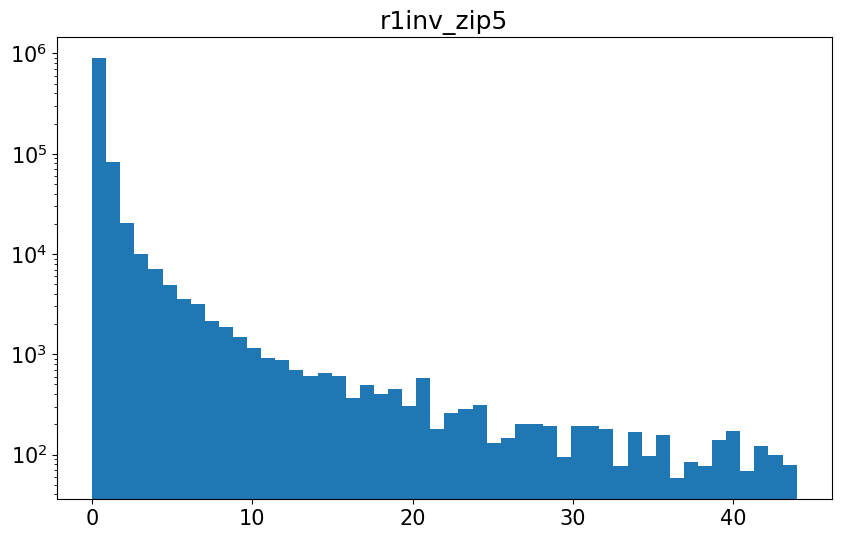

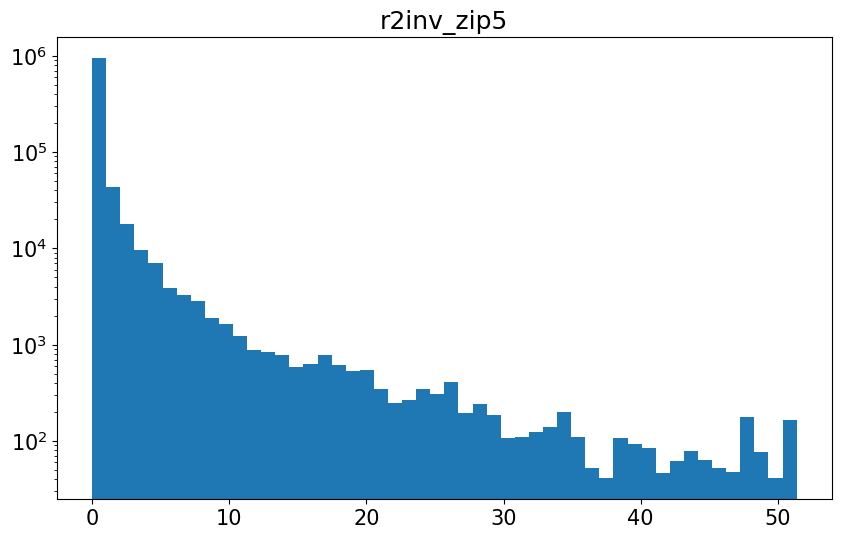

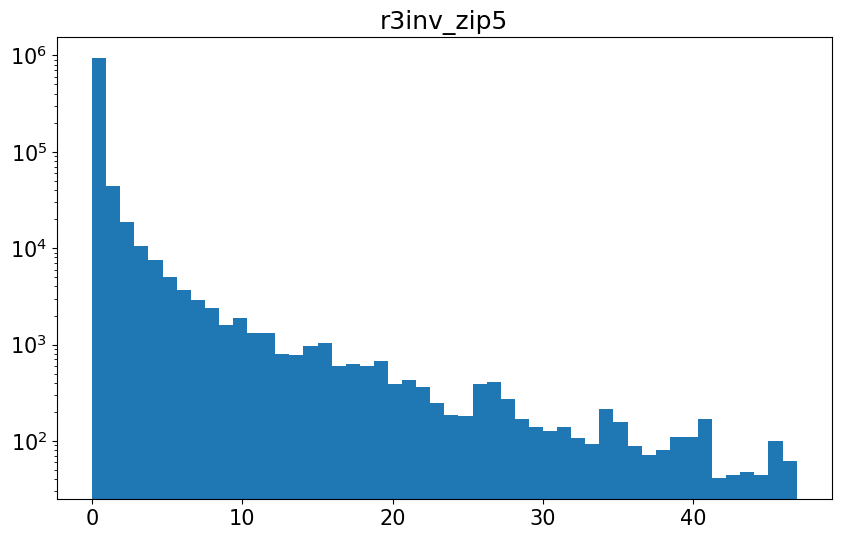

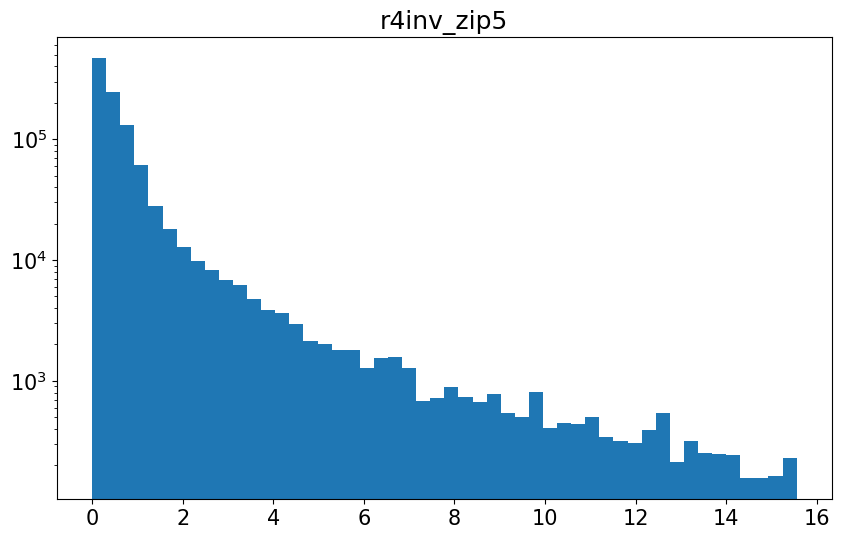

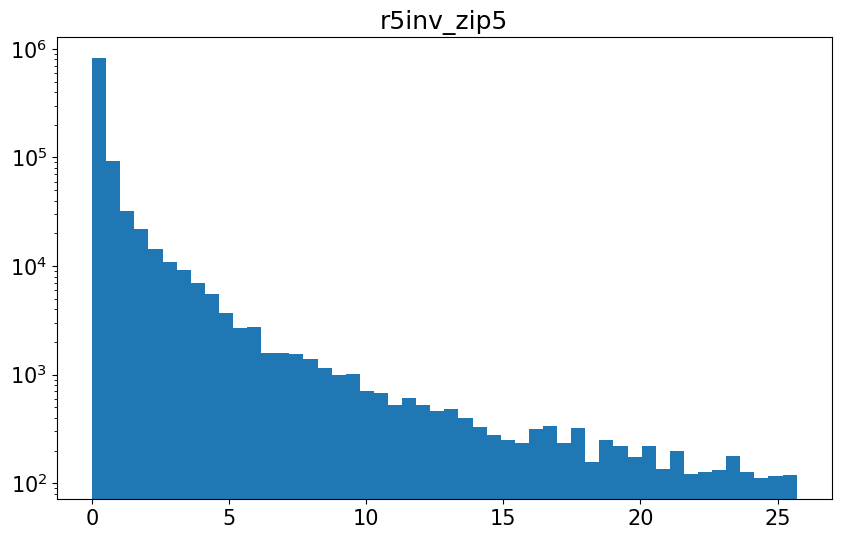

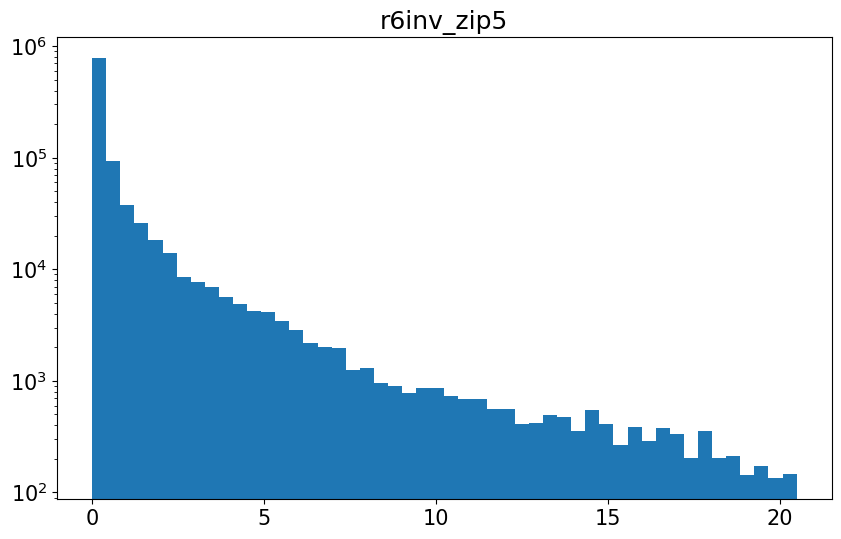

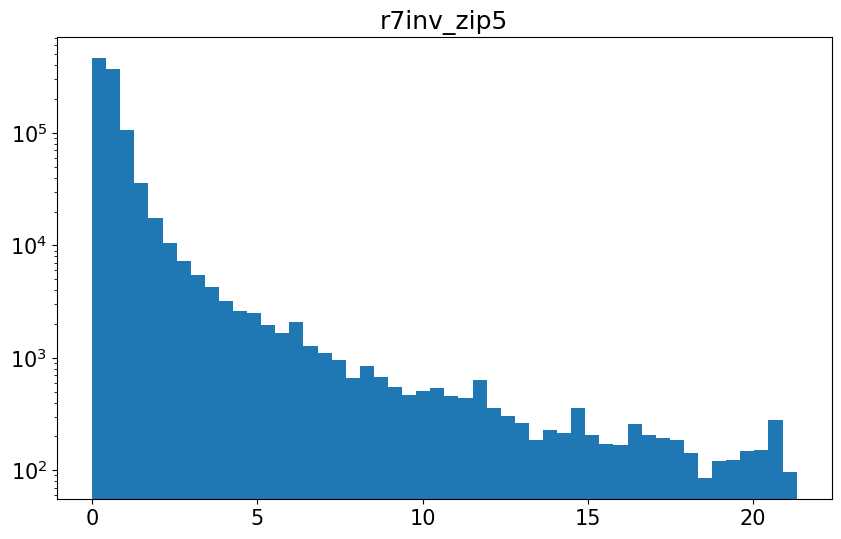

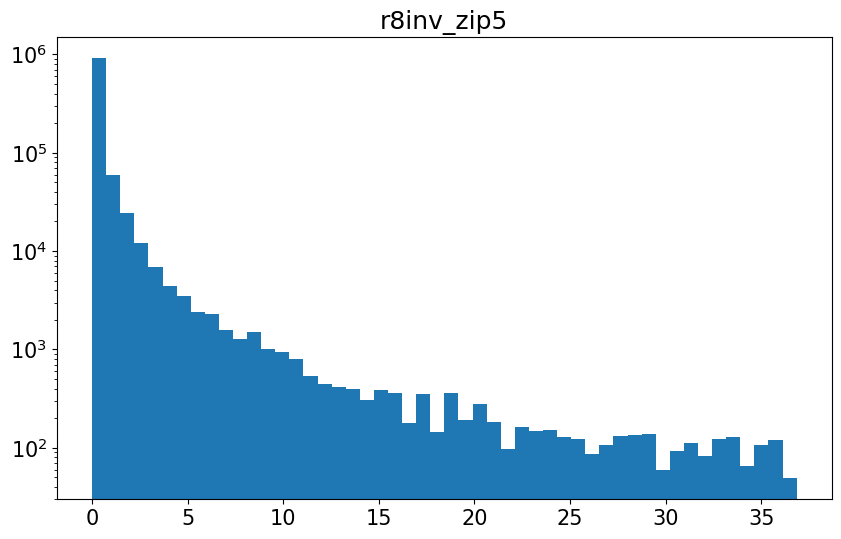

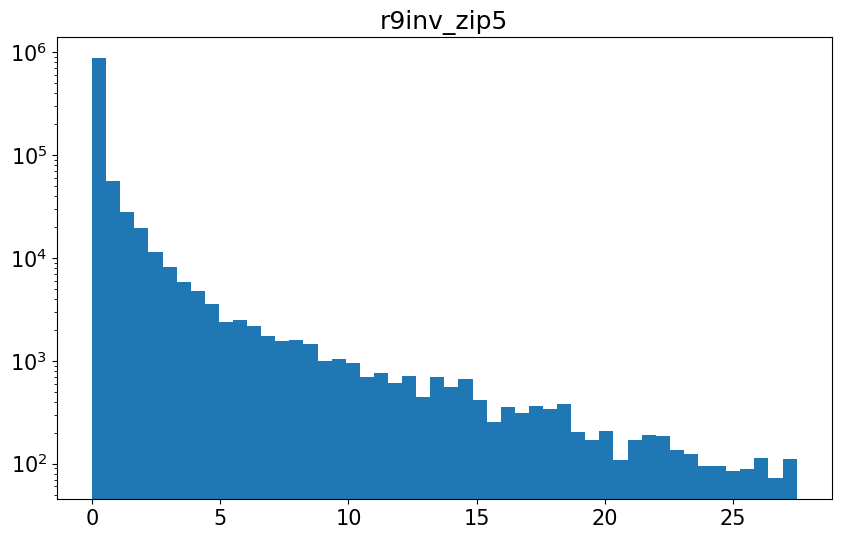

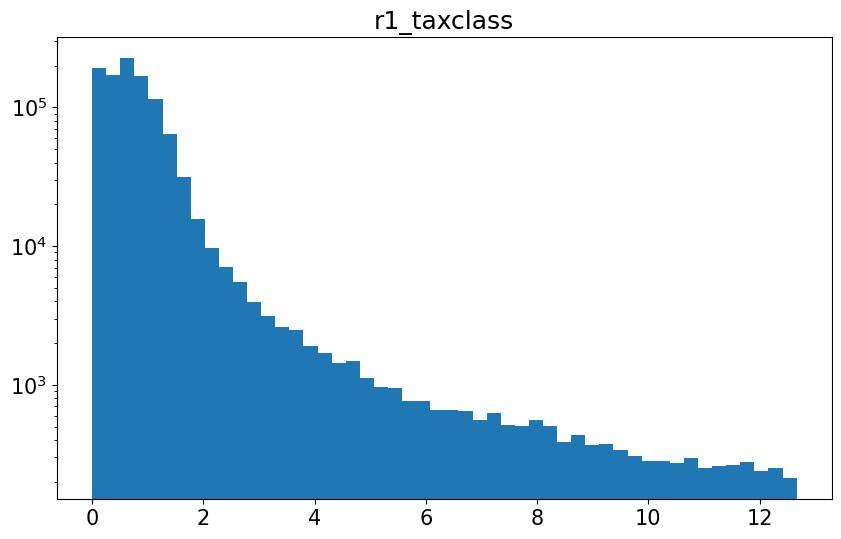

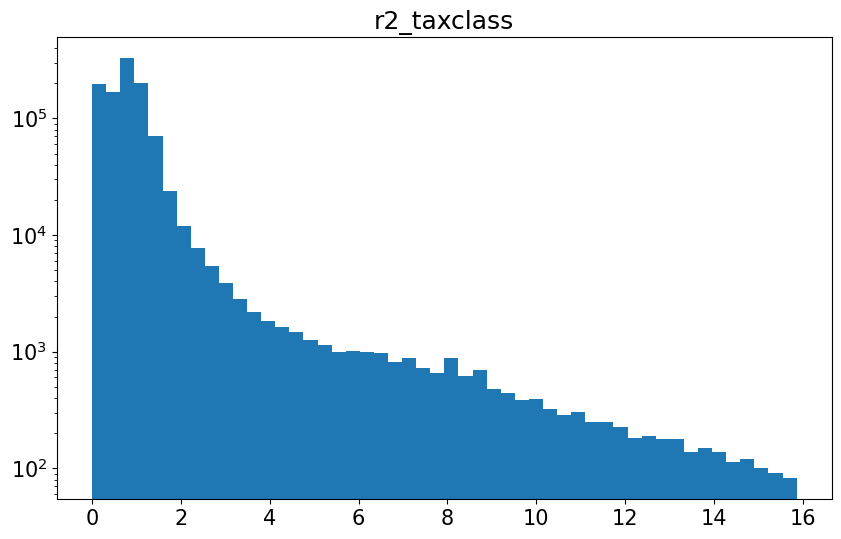

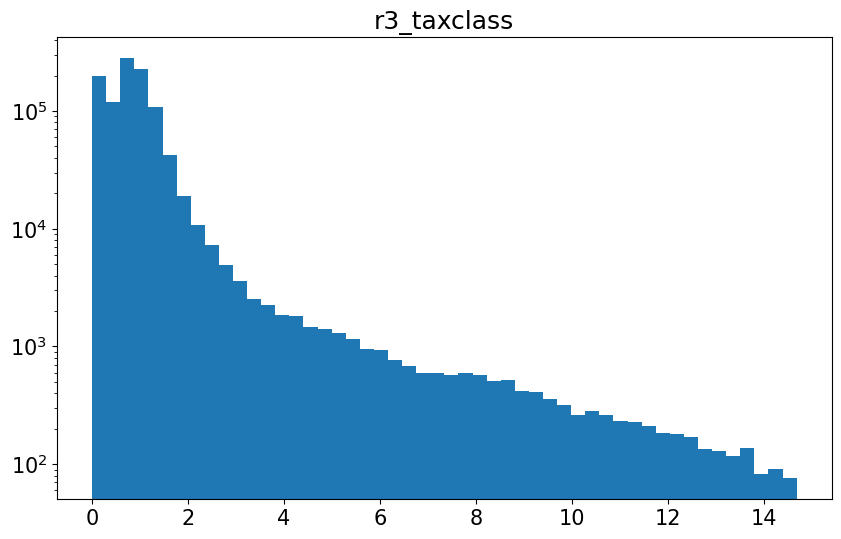

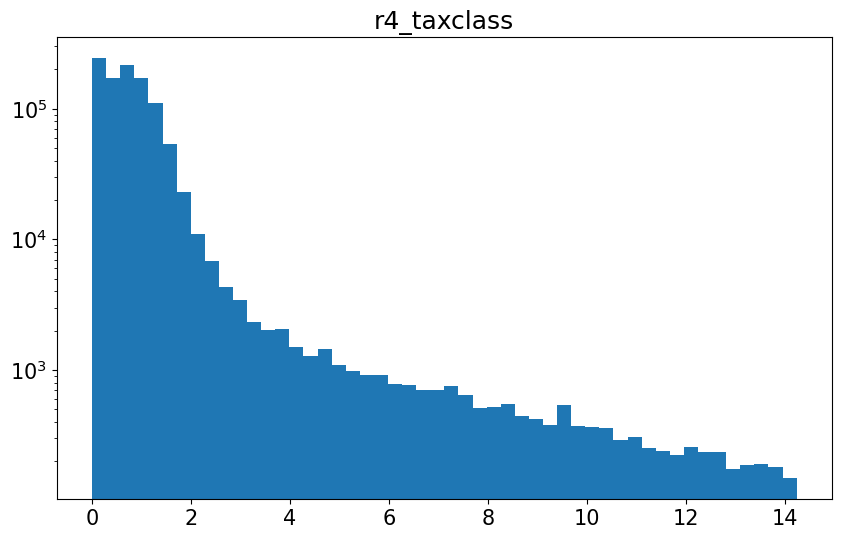

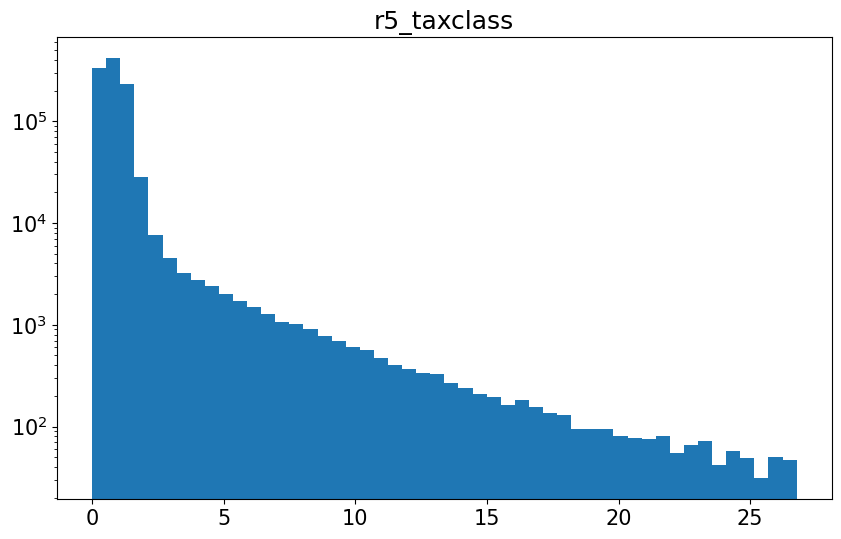

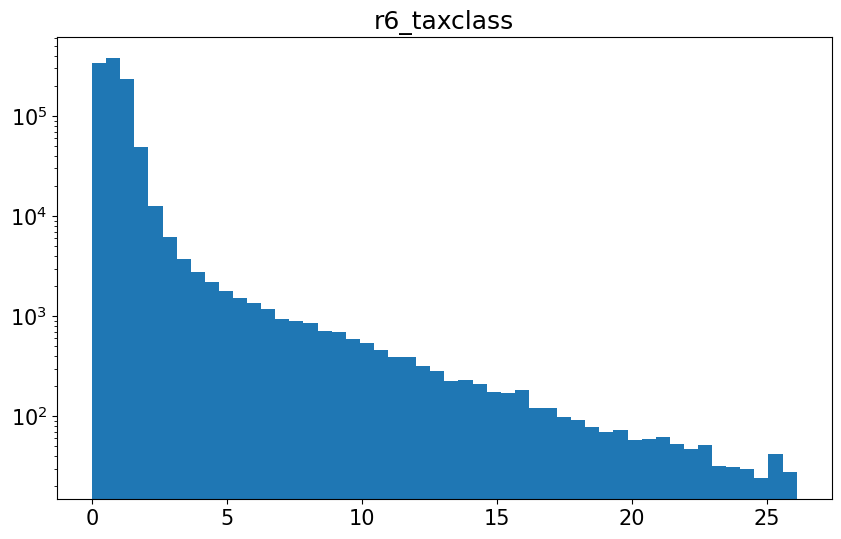

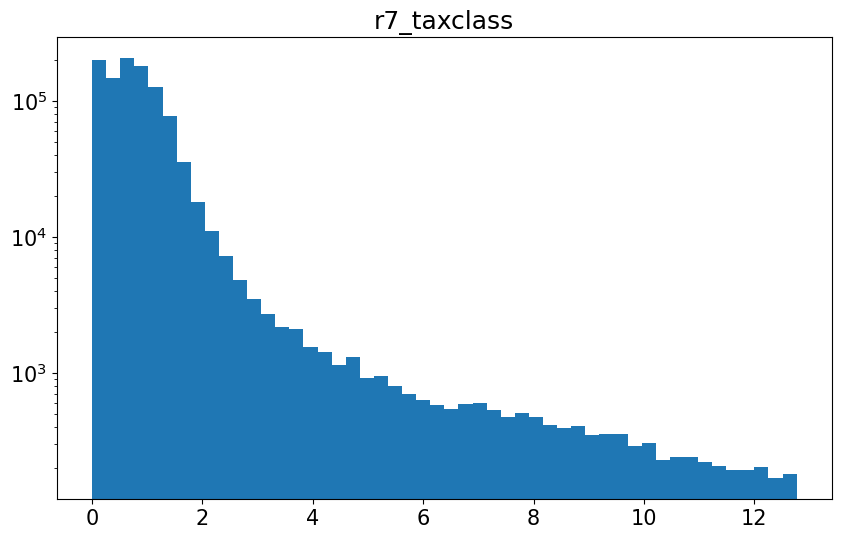

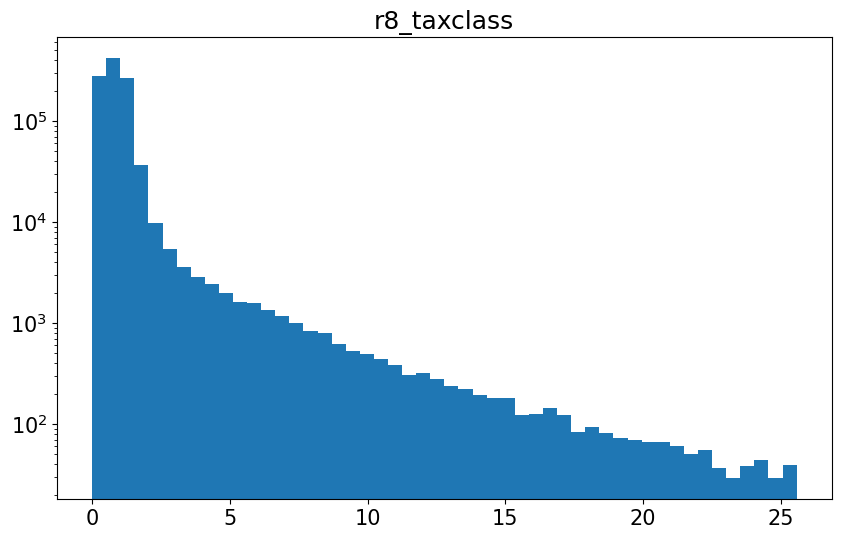

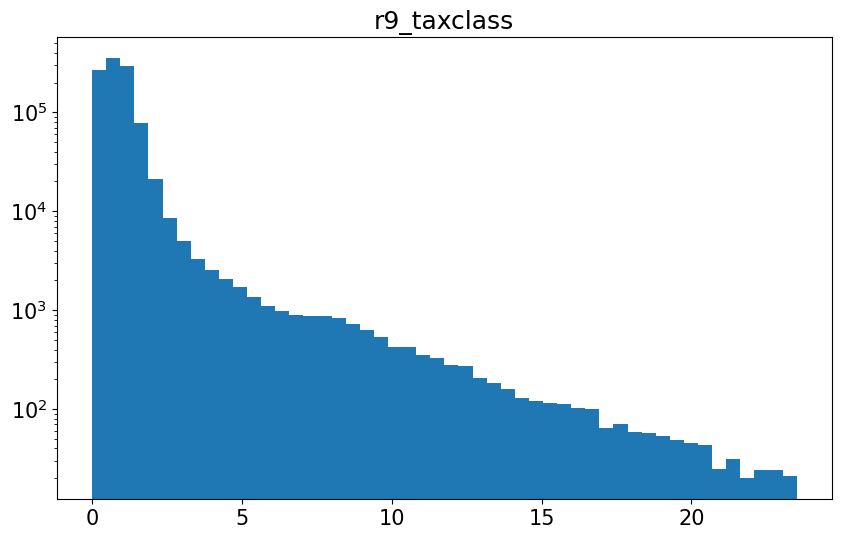

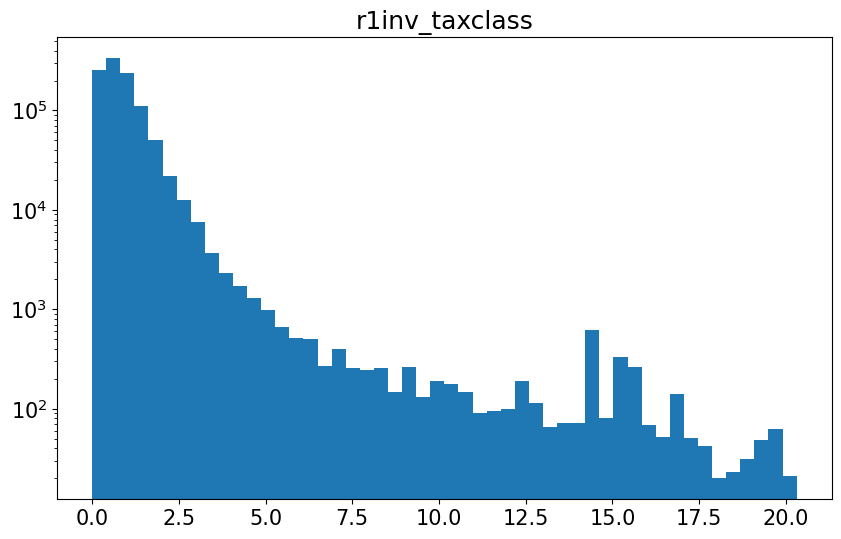

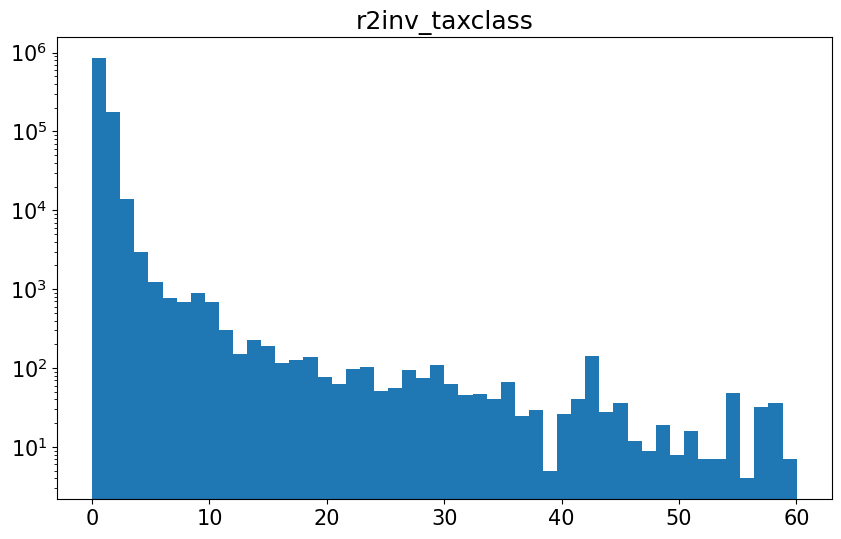

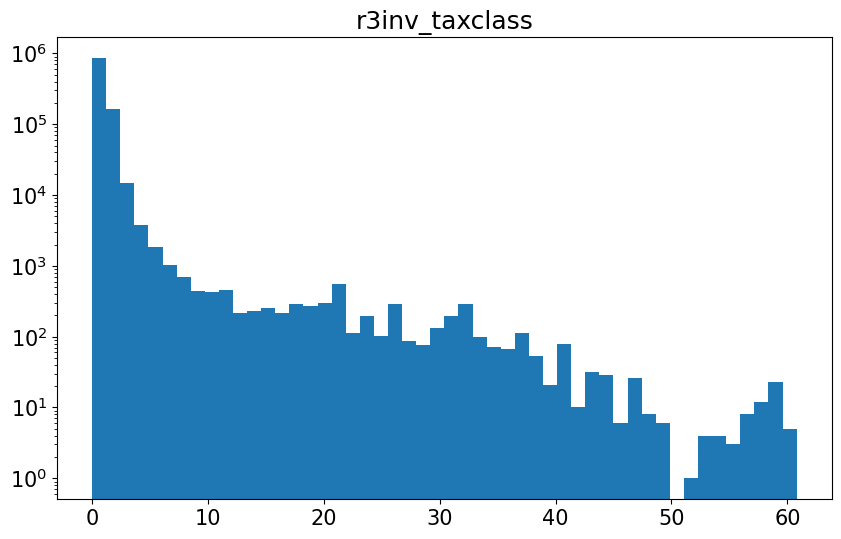

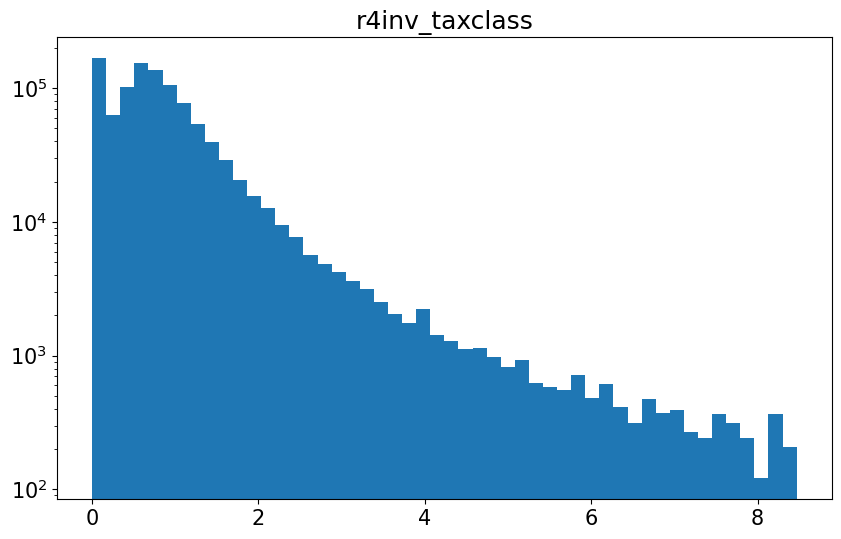

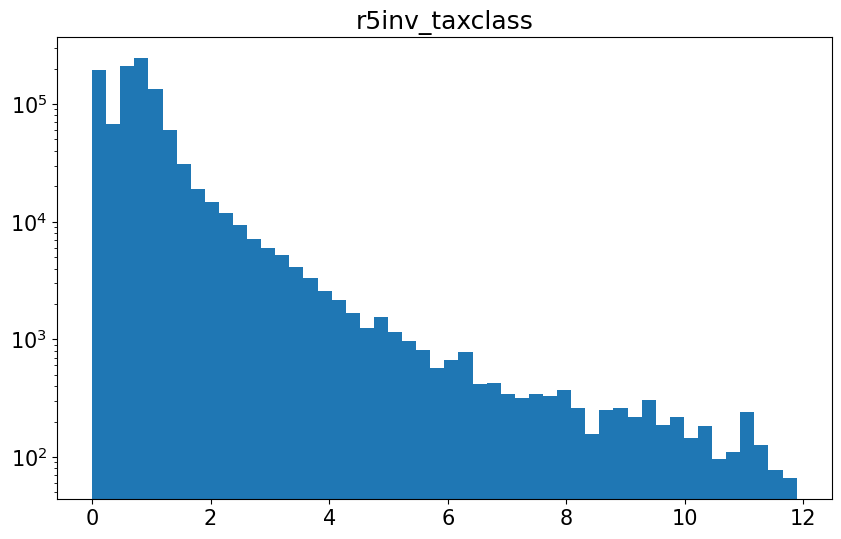

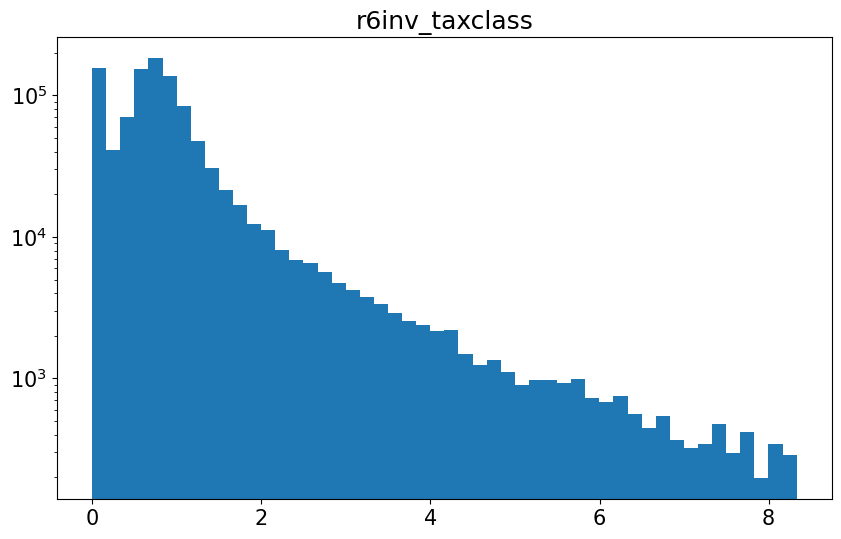

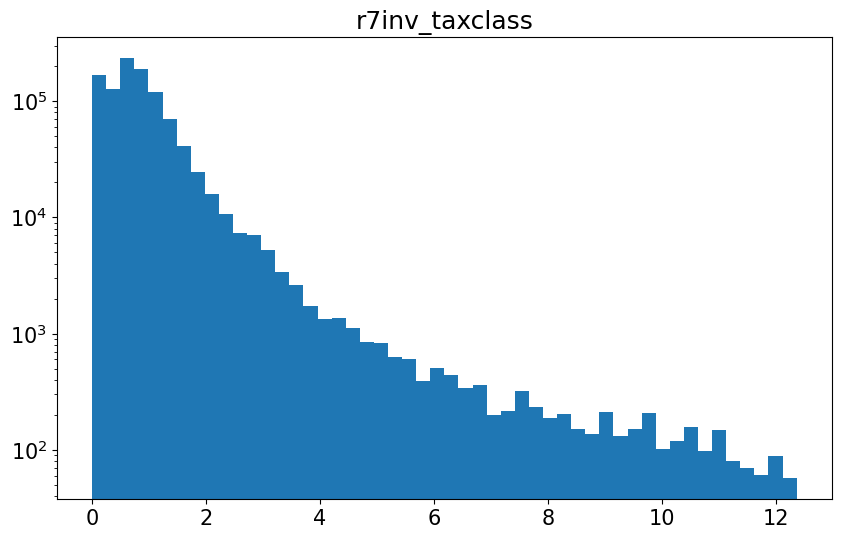

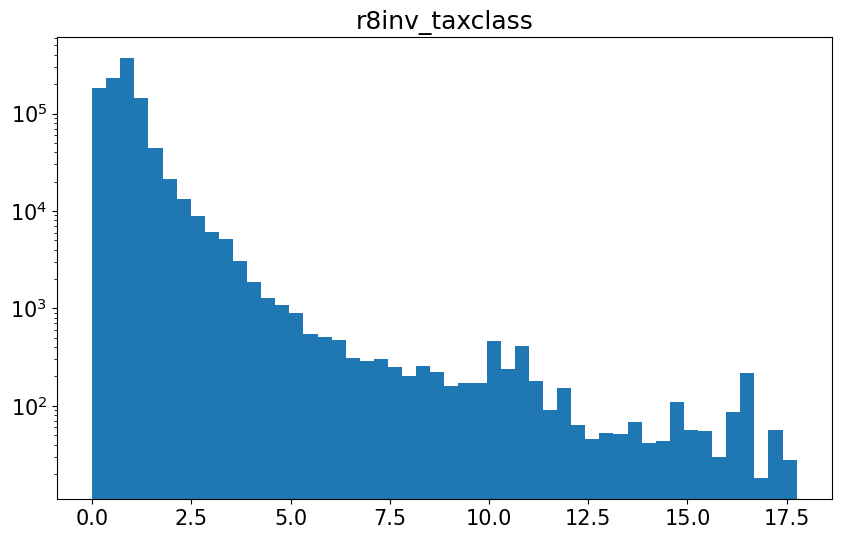

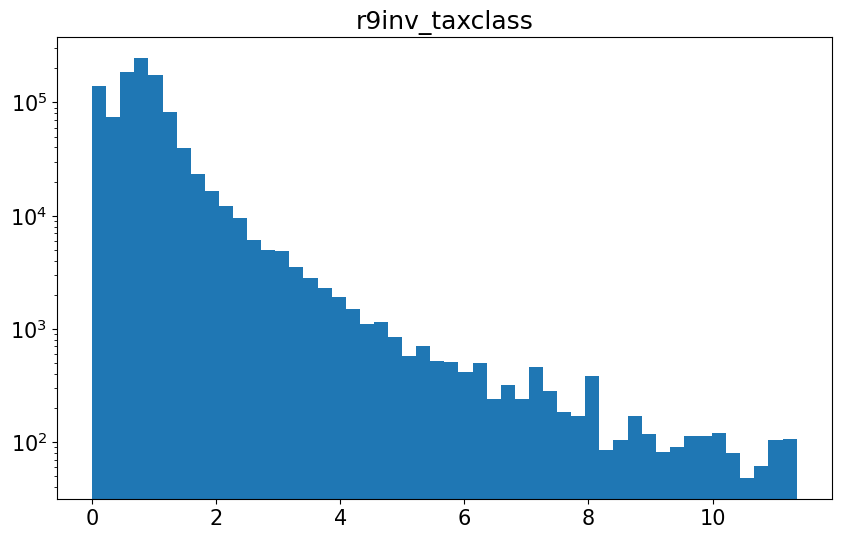

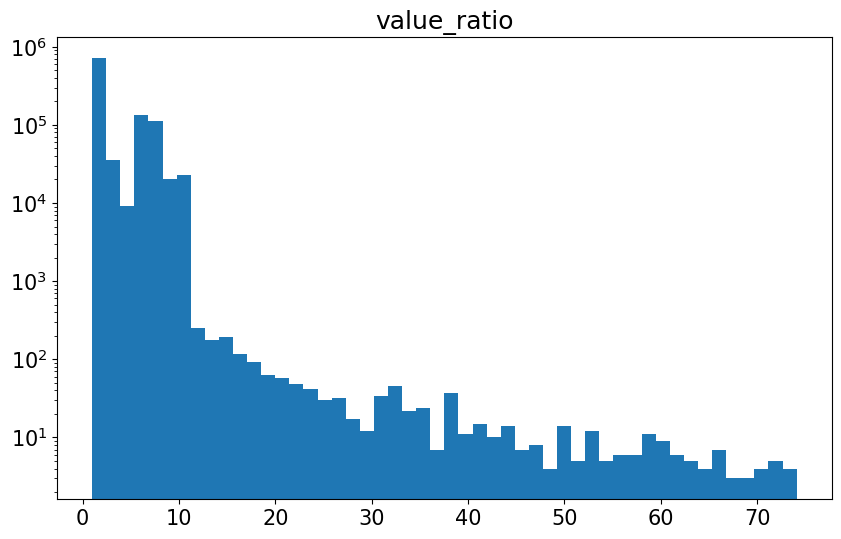

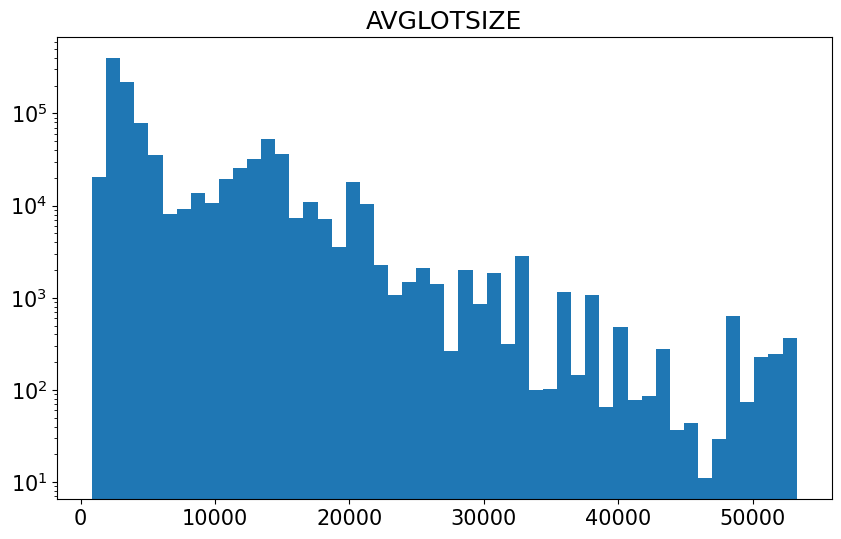

In [54]:
# %%time
# nstd = 4
# for col in data.columns:
#     plt.rcParams['figure.figsize'] = [10,6]
#     plt.figure()
#     plt.rcParams['font.size'] = 15
#     plt.yscale('log')
#     xstdev = data[col].std()
#     xmean = data[col].mean()
#     temp = data[data[col] <= xmean + nstd*xstdev]
#     temp = temp[data[col] >= xmean - nstd*xstdev]
#     plt.hist(temp[col],bins=50)
#     plt.title(col)

In [55]:
# data.to_csv('NY vars.csv', index=False)

In [56]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,AVGLOTSIZE
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-6.637515e-17,2.801661e-16,1.351946e-16,-5.806468e-17,-3.788598e-18,1.632220e-17,1.444827e-17,-1.865783e-17,-1.776160e-17,1.629505e-17,...,4.676678e-17,-3.481708e-17,-2.154205e-16,8.986717e-17,-2.259580e-16,-9.972568e-17,-1.549116e-16,2.539311e-17,-1.621357e-17,1.590396e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-9.412311e-02,...,-6.737479e-02,-6.636585e-02,-5.352064e-01,-3.669768e-01,-5.455804e-01,-3.516733e-01,-2.387159e-01,-3.861640e-01,-1.184163e-01,-5.135290e-01
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-8.940407e-02,...,-3.279211e-02,-3.240578e-02,-3.169409e-01,-1.913549e-01,-2.773283e-01,-1.938550e-01,-1.064324e-01,-1.802704e-01,-1.115971e-01,-3.734094e-01
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-8.661308e-02,...,-1.225936e-02,-1.318520e-02,-1.499729e-01,-8.985721e-02,-1.334652e-01,-9.356105e-02,-4.987762e-02,-8.146776e-02,-1.025660e-01,-2.798265e-01
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,-7.907924e-02,...,6.739030e-03,6.637216e-03,7.141198e-02,1.905684e-02,3.749616e-02,3.581319e-02,1.451196e-02,2.872642e-02,1.639690e-01,2.173493e-01
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,1.105466e+02,...,7.626817e+02,7.751231e+02,1.905214e+02,4.414327e+02,3.483293e+02,2.128912e+02,4.726452e+02,4.228196e+02,5.616993e+02,1.263348e+02


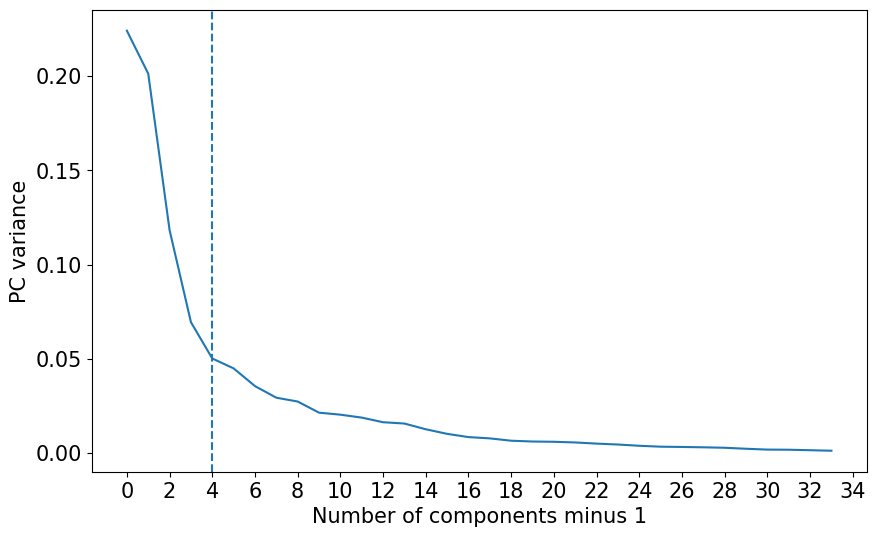

In [57]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

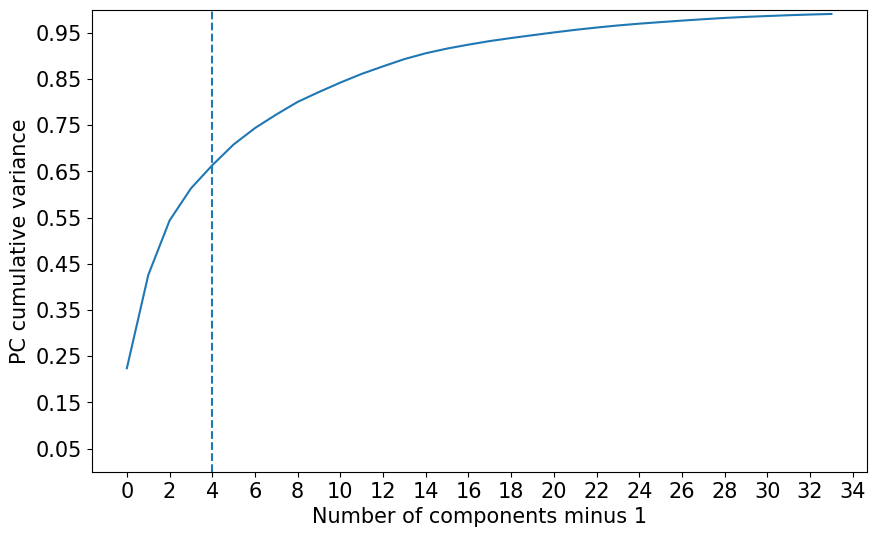

In [58]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [59]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 10 s, sys: 1.22 s, total: 11.3 s
Wall time: 3.35 s


4

In [60]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.2241305  0.42546454 0.54376804 0.61321282]


In [61]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046516, 4)

In [62]:
data_pca.head(5)

,PC1,PC2,PC3,PC4
0,5.655208,4.205613,-1.852930,-0.341090
1,93.714072,64.439274,179.606088,3.126152
2,0.858719,-0.470997,0.745181,-0.512231
3,1.317436,-0.138775,1.400010,-0.500673
4,2.259935,0.544209,2.748653,-0.450275


In [63]:
data_pca.describe()

,PC1,PC2,PC3,PC4
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-3.345916e-17,-2.259580e-17,8.066047e-17,-1.325330e-17
std,3.542783e+00,3.357783e+00,2.573907e+00,1.972031e+00
min,-3.294891e+02,-1.216547e+00,-6.418891e+02,-1.098603e+02
25%,-1.094689e-01,-5.067593e-01,-4.240392e-01,-1.958002e-01
50%,3.004687e-01,-4.048907e-01,-2.081841e-01,5.959432e-02
75%,5.517804e-01,-2.344472e-01,3.594331e-02,1.875175e-01
max,1.538997e+03,1.585031e+03,7.670470e+02,1.139540e+03


In [64]:
# zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,3.041742e-18,-5.431682e-18,-4.855924e-17,-1.819613e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.300291e+01,-3.623067e-01,-2.493832e+02,-5.570923e+01
25%,-3.089913e-02,-1.509208e-01,-1.647454e-01,-9.928858e-02
50%,8.481149e-02,-1.205828e-01,-8.088254e-02,3.021976e-02
75%,1.557477e-01,-6.982204e-02,1.396450e-02,9.508852e-02
max,4.344035e+02,4.720469e+02,2.980089e+02,5.778508e+02


In [65]:
data_pca_zs.shape

(1046516, 4)

In [66]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4
0,1.596262,1.252497,-0.719890,-0.172964
1,26.452110,19.191018,69.779563,1.585245
2,0.242385,-0.140270,0.289514,-0.259748
3,0.371865,-0.041329,0.543924,-0.253887
4,0.637898,0.162074,1.067891,-0.228331


## Now calculate two unsupervised fraud scores

In [67]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 1000

### Calculate score 1

In [68]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     2.159851
1    77.069512
2     0.479284
3     0.707322
4     1.275033
5     0.406566
6     0.372093
7     0.370881
8     1.019390
9     0.986613
dtype: float64

In [69]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4
0,1.596262,1.252497,-0.719890,-0.172964
1,26.452110,19.191018,69.779563,1.585245
2,0.242385,-0.140270,0.289514,-0.259748
3,0.371865,-0.041329,0.543924,-0.253887
4,0.637898,0.162074,1.067891,-0.228331
5,0.006432,-0.284580,-0.132925,-0.258070
6,0.118989,-0.228248,0.054280,-0.263156
7,0.109032,-0.234706,0.036032,-0.263210
8,0.520062,0.074564,0.838145,-0.246263
9,0.505065,0.062768,0.808292,-0.247058


In [70]:
score1.max()

688.4471087491886

### Autoencoder for score 2

In [71]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)


CPU times: user 19.9 s, sys: 98.5 ms, total: 20 s
Wall time: 20 s


/Users/ankur/tensorflow-test/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [72]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [73]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,2.159851,2.025322,1
1,77.069512,44.712033,2
2,0.479284,0.163062,9
3,0.707322,0.214331,10
4,1.275033,0.325178,11
5,0.406566,0.114211,12
6,0.372093,0.127075,13
7,0.370881,0.125137,14
8,1.019390,0.277525,15
9,0.986613,0.271108,16


In [74]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,2.159851,2.025322,1,1016908.0,1043662.0
1,77.069512,44.712033,2,1046460.0,1046442.0
2,0.479284,0.163062,9,865414.0,931913.0
3,0.707322,0.214331,10,938381.0,967440.0
4,1.275033,0.325178,11,994340.0,998858.0
5,0.406566,0.114211,12,763174.0,818398.0
6,0.372093,0.127075,13,687722.0,865756.0
7,0.370881,0.125137,14,684977.0,860326.0
8,1.019390,0.277525,15,979605.0,988385.0
9,0.986613,0.271108,16,976714.0,986807.0


In [75]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,2.159851,2.025322,1,1016908.0,1043662.0,1030285.0
1,77.069512,44.712033,2,1046460.0,1046442.0,1046451.0
2,0.479284,0.163062,9,865414.0,931913.0,898663.5
3,0.707322,0.214331,10,938381.0,967440.0,952910.5
4,1.275033,0.325178,11,994340.0,998858.0,996599.0
5,0.406566,0.114211,12,763174.0,818398.0,790786.0
6,0.372093,0.127075,13,687722.0,865756.0,776739.0
7,0.370881,0.125137,14,684977.0,860326.0,772651.5
8,1.019390,0.277525,15,979605.0,988385.0,983995.0
9,0.986613,0.271108,16,976714.0,986807.0,981760.5


In [76]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
567117,688.447109,679.765067,917942,1046516.0,1046516.0,1046516.0
921008,594.653419,576.525525,956520,1046515.0,1046515.0,1046515.0
628158,513.903786,495.798637,658933,1046514.0,1046514.0,1046514.0
1040897,305.562035,274.910813,1059883,1046513.0,1046513.0,1046513.0
56798,237.971815,207.499223,139726,1046512.0,1046511.0,1046511.5
678871,236.731033,230.722905,665158,1046511.0,1046512.0,1046511.5
54172,225.091282,194.421450,116647,1046510.0,1046510.0,1046510.0
682902,214.969545,184.592508,684704,1046509.0,1046509.0,1046509.0
300423,201.160933,183.101559,333412,1046508.0,1046508.0,1046508.0
11205,189.008845,182.667144,12076,1046507.0,1046507.0,1046507.0


In [77]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
887057,0.148829,0.009001,852339,1515.0,1556.0,1535.5
887052,0.148829,0.009001,852334,1515.0,1556.0,1535.5
665849,0.146988,0.009273,860294,1261.0,1758.0,1509.5
665846,0.139328,0.009620,860291,715.0,1957.0,1336.0
732079,0.133156,0.009547,708935,500.0,1918.0,1209.0
826308,0.151809,0.004971,840953,2178.0,201.0,1189.5
293302,0.128488,0.008610,426737,404.0,1365.0,884.5
826665,0.144150,0.005916,841316,989.0,382.0,685.5
834863,0.136335,0.005960,788292,583.0,387.0,485.0
420430,0.125000,0.005069,492696,350.0,219.0,284.5


In [78]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.210324e-01,1.287957e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,1.930939e+00,1.398065e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.804726e+05
min,4.064212e-02,1.408086e-03,1.000000e+00,1.000000e+00,1.000000e+00,2.845000e+02
25%,2.150452e-01,5.012191e-02,2.731068e+05,2.616298e+05,2.616298e+05,2.750660e+05
50%,2.619614e-01,7.606565e-02,5.389795e+05,5.232585e+05,5.232585e+05,5.331175e+05
75%,4.175879e-01,1.081219e-01,8.026112e+05,7.848820e+05,7.848886e+05,7.444954e+05
max,6.884471e+02,6.797651e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [79]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.210324e-01,1.287957e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,1.930939e+00,1.398065e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.804726e+05
min,4.064212e-02,1.408086e-03,1.000000e+00,1.000000e+00,1.000000e+00,2.845000e+02
25%,2.150452e-01,5.012191e-02,2.731068e+05,2.616298e+05,2.616298e+05,2.750660e+05
50%,2.619614e-01,7.606565e-02,5.389795e+05,5.232585e+05,5.232585e+05,5.331175e+05
75%,4.175879e-01,1.081219e-01,8.026112e+05,7.848820e+05,7.848886e+05,7.444954e+05
max,6.884471e+02,6.797651e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [80]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,688.447109,679.765067,1046516.0,1046516.0,1046516.0
956520,594.653419,576.525525,1046515.0,1046515.0,1046515.0
658933,513.903786,495.798637,1046514.0,1046514.0,1046514.0
1059883,305.562035,274.910813,1046513.0,1046513.0,1046513.0
139726,237.971815,207.499223,1046512.0,1046511.0,1046511.5
665158,236.731033,230.722905,1046511.0,1046512.0,1046511.5
116647,225.091282,194.421450,1046510.0,1046510.0,1046510.0
684704,214.969545,184.592508,1046509.0,1046509.0,1046509.0
333412,201.160933,183.101559,1046508.0,1046508.0,1046508.0


(0.1, 2078887.8987621546)

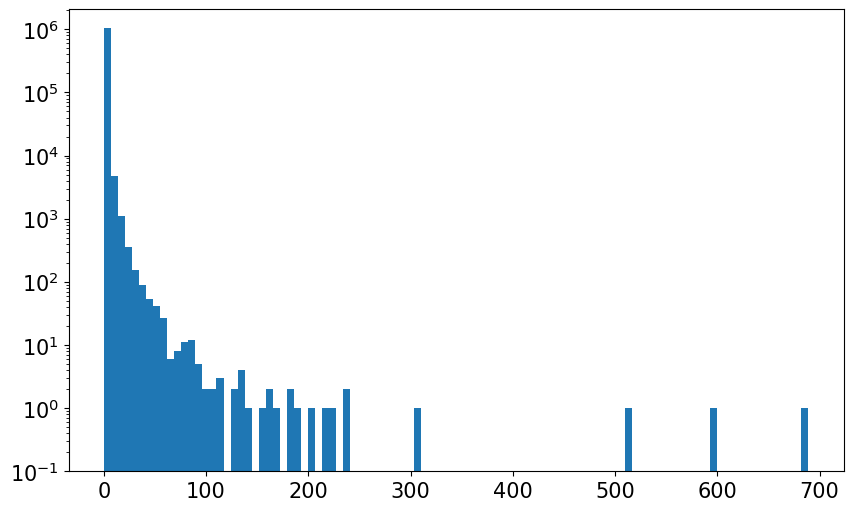

In [81]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [82]:
sc2max = int(score2.max())
sc2max

679

679


(0.1, 2091284.991182093)

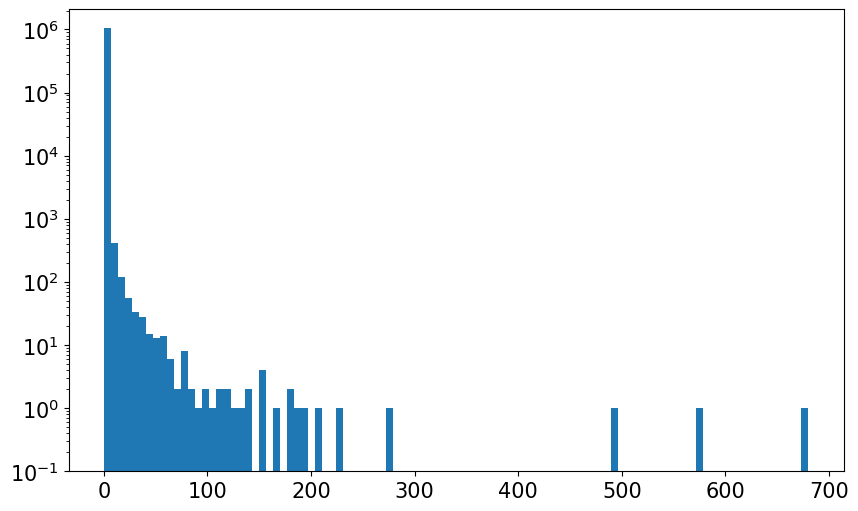

In [83]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([  395.,  1350.,  2909.,  4390.,  5813.,  6726.,  7274.,  8877.,
        10086., 10530., 10865., 11668., 11905., 12349., 12706., 12874.,
        12986., 12898., 12907., 12751., 12983., 12783., 12542., 12715.,
        12324., 12631., 12673., 12617., 12209., 12763., 13105., 12564.,
        11960., 12049., 11313., 10892., 10483.,  9963.,  9700.,  9543.,
         9714.,  9672.,  9330.,  9308.,  9064.,  9404.,  9196.,  9362.,
         9588.,  9600.,  9546.,  9443.,  9328.,  9602.,  9532.,  9876.,
        10660., 11359., 11833., 15615., 16848., 16674., 15317., 14959.,
        14399., 14544., 14275., 14095., 13947., 13445., 13401., 13532.,
        12467., 12351., 11840., 11284., 11209., 10523.,  8816.,  8364.,
         8773.,  8813.,  7561.,  6474.,  6641.,  6856.,  6830.,  7385.,
         7675.,  7961.,  7725.,  7694.,  7937.,  8276.,  9390.,  8895.,
         9792.,  9981., 11507.,  6957.]),
 array([2.84500000e+02, 1.07468150e+04, 2.12091300e+04, 3.16714450e+04,
        4.21337600e+04

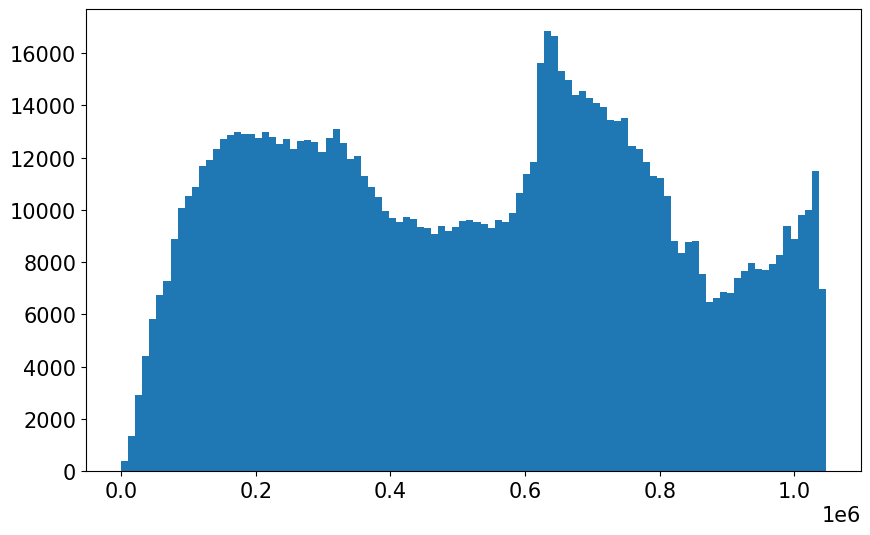

In [84]:
plt.hist(scores['final'],bins=100)

In [85]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Index([ 917942,  956520,  658933, 1059883,  139726,  665158,  116647,  684704,
        333412,   12076,
       ...
         87432,  133310,  133311,  850235,  835226, 1069996,  319791,   38582,
        774732, 1063550],
      dtype='int64', name='RECORD', length=1000)


In [86]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,AVGLOTSIZE
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.326552,3.406992,0.987422,-0.034199,2.052445,0.766972,-0.041524,1.879522,0.949207,-0.066039,...,-0.067325,-0.066321,-0.512577,-0.366754,-0.545038,-0.327433,-0.238511,-0.385804,0.267780,3.711622
2,108.917366,35.106980,12.980793,61.297815,7.095909,2.734592,128.820205,17.456997,9.068879,-0.094112,...,-0.067370,-0.066361,-0.535172,-0.366912,-0.545421,-0.351663,-0.238694,-0.386125,0.188881,3.711622
9,0.327495,0.197416,-0.471032,0.747304,0.257310,-0.043784,0.729977,0.302327,-0.038185,-0.091157,...,-0.067101,-0.064141,-0.532278,-0.365497,-0.513024,-0.349113,-0.237603,-0.368462,0.244919,3.711622
10,0.653138,0.520331,-0.457550,1.147030,0.398936,-0.037686,1.114097,0.461008,-0.029058,-0.092074,...,-0.067185,-0.064826,-0.533182,-0.365953,-0.523024,-0.349904,-0.237946,-0.373909,0.244919,3.711622
11,1.561562,1.421145,-0.419941,1.215100,0.423053,-0.036648,2.185654,0.903671,-0.003596,-0.093025,...,-0.067273,-0.065538,-0.533284,-0.366004,-0.524145,-0.350725,-0.238302,-0.379570,0.200154,3.711622


In [87]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,917942,956520,658933,1059883,139726,665158,116647,684704,333412,12076,...,87432,133310,133311,850235,835226,1069996,319791,38582,774732,1063550
r1,0.756214,-0.114376,0.183338,204.973756,256.318188,-0.388437,162.065400,176.589777,-0.392110,0.040929,...,4.348140,-0.403877,-0.403877,-0.366697,-0.338880,-0.403939,8.753850,19.860316,-0.337749,-0.403940
r2,68.244847,-0.527888,-0.527871,-0.028963,-0.028963,133.268367,4.437754,-0.415113,-0.527873,102.253881,...,10.592616,-0.527850,-0.527850,-0.526536,-0.515521,-0.527896,-0.375202,4.587700,-0.524760,-0.527323
r3,47.353074,-0.501288,-0.501277,-0.312537,-0.312537,278.798453,-0.205147,-0.442440,-0.501278,214.055711,...,1.609061,-0.501301,-0.501301,-0.500589,-0.494841,-0.501304,-0.448180,-0.269165,-0.499663,-0.501000
r4,42.183218,-0.051803,0.004642,253.722524,317.190798,-0.097632,147.455998,32.895634,-0.111954,1.367632,...,5.209176,-0.150543,-0.150543,-0.143368,-0.149341,-0.150454,1.749822,11.452211,-0.140679,-0.150555
r5,896.559351,-0.060808,-0.060808,0.159563,0.159563,162.835033,1.551116,-0.053287,-0.060752,125.257416,...,4.420615,-0.060805,-0.060805,-0.060717,-0.060729,-0.060777,-0.049489,0.985743,-0.060644,-0.060719
r6,643.287451,-0.057476,-0.057476,0.028497,0.028497,350.586709,0.041657,-0.053429,-0.057435,269.698378,...,0.819482,-0.057478,-0.057478,-0.057428,-0.057434,-0.057465,-0.053417,-0.008506,-0.057388,-0.057428
r7,37.825491,-0.087301,-0.040477,251.373336,314.249882,-0.114522,191.512459,11.251048,-0.118854,0.391949,...,5.472640,-0.132735,-0.132735,-0.130368,-0.132425,-0.132808,10.669520,23.770462,-0.129442,-0.132843
r8,937.306848,-0.054106,-0.054105,0.200443,0.200443,65.693812,2.386043,-0.051086,-0.054082,50.453196,...,5.410561,-0.054071,-0.054071,-0.054070,-0.054075,-0.054094,0.020941,2.459727,-0.054041,-0.054071
r9,898.551545,-0.058685,-0.058684,0.073996,0.073996,189.030971,0.141822,-0.056514,-0.058662,145.199273,...,1.370065,-0.058678,-0.058678,-0.058659,-0.058663,-0.058680,-0.022714,0.098481,-0.058638,-0.058660
r1inv,-0.092256,-0.086620,-0.090428,-0.094121,-0.094123,0.045731,-0.094118,-0.094119,0.088957,-0.089242,...,-0.093674,18.869980,18.869980,-0.035799,-0.060720,41.236036,-0.093894,-0.094024,-0.061290,41.929624


In [88]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1016908.0,1043662.0,1030285.0
2,1046460.0,1046442.0,1046451.0
9,865414.0,931913.0,898663.5
10,938381.0,967440.0,952910.5
11,994340.0,998858.0,996599.0
12,763174.0,818398.0,790786.0
13,687722.0,865756.0,776739.0
14,684977.0,860326.0,772651.5
15,979605.0,988385.0,983995.0


In [89]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores



,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1016908.0,1043662.0,1030285.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046460.0,1046442.0,1046451.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,517845.0,660475.0,589160.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,874237.0,829563.0,851900.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,605063.0,900014.0,752538.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,435740.0,902791.0,669265.5


In [90]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0
139726,1020440122,1,2044,122,NaN,"BRADHURST EQUITIES, L",V1,4,4,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046512.0,1046511.0,1046511.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069996,5080200123E,5,8020,123,E,NY STATE PUBLIC SERV,Z7,4,123,73,...,6.200000e+01,6.200000e+01,6.200000e+01,NaN,FINAL,2010/11,AC-TR,1045963.0,1043967.0,1044965.0
38582,1007840041,1,784,41,NaN,450 7TH AVE ASSCTS,O4,4,108,60,...,2.802600e+07,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044469.0,1045456.0,1044962.5
319791,3016910012,3,1691,12,NaN,FULTON PARK SITE 4 HO,D1,2,25,100,...,5.580000e+06,3.341700e+05,5.580000e+06,NaN,FINAL,2010/11,AC-TR,1044294.0,1045631.0,1044962.5


In [91]:
NY_data_top_n.to_excel('output.xlsx', index=True)


In [92]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1016908.0,1043662.0,1030285.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046460.0,1046442.0,1046451.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,865414.0,931913.0,898663.5
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,938381.0,967440.0,952910.5


In [93]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
956520         TROMPETA RIZALINA
658933           WAN CHIU CHEUNG
1059883                      NaN
139726     BRADHURST EQUITIES, L
665158         ST JOHNS CEMETERY
116647      MF ASSOCIATES OF NEW
684704                  W RUFERT
333412            SPOONER ALSTON
12076      15 WORTH STREET PROPE
382398            MARINO FRANK R
252834                       NaN
665157         ST JOHNS CEMETERY
330291           PRATT INSTITUTE
106681           79TH REALTY LLC
638993     ALEXANDER'S OF REGOPA
33564        HLP PROPERTIES, LLC
1065870    PEOPLE OF THE ST OF N
330292           PRATT INSTITUTE
288274                       NaN
39770      GREENHORN DEVELOPMENT
610682            DEBORAH WILSON
820884     JAMAICA FIRST PARKING
95995        BERGAMINI, JENNIFER
86946       712 FIFTH AVENUE L P
151044                       NaN
14979           ENJAY ASSOCIATES
33751             GUIDARA, FRANK
649675              NEWFOUND LLC
47984      BERKOWTIZ, ULWT LOUIS
712

In [91]:
NY_data_top_n.shape

(1000, 34)

In [92]:
data_zs_top_n.shape

(1000, 55)

In [93]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(1000, 89)

In [94]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [95]:
NY_top_with_zs.head(5).transpose()

RECORD,917942,956520,658933,1059883,139726
BBLE,4142600001,5006590012,4029060054,5069770012E,1020440122
BORO,4,5,4,5,1
BLOCK,14260,659,2906,6977,2044
LOT,1,12,54,12,122
EASEMENT,NaN,NaN,NaN,E,NaN
...,...,...,...,...,...
r6inv_taxclass,-0.54558,348.329263,346.042086,-0.540377,-0.540377
r7inv_taxclass,-0.351622,-0.081502,-0.218385,-0.351672,-0.351673
r8inv_taxclass,-0.238716,472.645202,436.131609,-0.237157,-0.237157
r9inv_taxclass,-0.386164,422.819577,409.752977,-0.383426,-0.383426


In [96]:
pd.set_option('display.max_columns', 20)

In [97]:
pd.set_option('display.max_columns', 20)

NY_top_with_zs.head(5).transpose()

RECORD,917942,956520,658933,1059883,139726
BBLE,4142600001,5006590012,4029060054,5069770012E,1020440122
BORO,4,5,4,5,1
BLOCK,14260,659,2906,6977,2044
LOT,1,12,54,12,122
EASEMENT,NaN,NaN,NaN,E,NaN
...,...,...,...,...,...
r6inv_taxclass,-0.54558,348.329263,346.042086,-0.540377,-0.540377
r7inv_taxclass,-0.351622,-0.081502,-0.218385,-0.351672,-0.351673
r8inv_taxclass,-0.238716,472.645202,436.131609,-0.237157,-0.237157
r9inv_taxclass,-0.386164,422.819577,409.752977,-0.383426,-0.383426


In [98]:
pd.set_option('display.max_columns', None)

In [99]:
NY_top_with_zs.head(5).transpose().iloc[:,:20]


RECORD,917942,956520,658933,1059883,139726
BBLE,4142600001,5006590012,4029060054,5069770012E,1020440122
BORO,4,5,4,5,1
BLOCK,14260,659,2906,6977,2044
LOT,1,12,54,12,122
EASEMENT,NaN,NaN,NaN,E,NaN
...,...,...,...,...,...
r6inv_taxclass,-0.54558,348.329263,346.042086,-0.540377,-0.540377
r7inv_taxclass,-0.351622,-0.081502,-0.218385,-0.351672,-0.351673
r8inv_taxclass,-0.238716,472.645202,436.131609,-0.237157,-0.237157
r9inv_taxclass,-0.386164,422.819577,409.752977,-0.383426,-0.383426


In [100]:
NY_top_with_zs.head()

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv,r1_zip5,r2_zip5,r3_zip5,r4_zip5,r5_zip5,r6_zip5,r7_zip5,r8_zip5,r9_zip5,r1inv_zip5,r2inv_zip5,r3inv_zip5,r4inv_zip5,r5inv_zip5,r6inv_zip5,r7inv_zip5,r8inv_zip5,r9inv_zip5,r1_taxclass,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,NaN,3.0,374019883.0,1.792809e+09,4.668309e+09,1.792809e+09,4.668309e+09,2198.0,154-68 BROOKVILLE BOULEVARD,11422.0,X4,0,0,1.644454e+09,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0,0.756214,68.244847,47.353074,42.183218,896.559351,643.287451,37.825491,937.306848,898.551545,-0.092256,-0.073195,-0.151133,-0.247658,-0.189264,-0.328783,-0.172341,-0.112761,-0.211578,2.154658,66.568942,31.440010,102.365975,635.118598,429.918996,146.215502,767.876246,631.158569,-0.082302,-0.078996,-0.086903,-0.274550,-0.161608,-0.205337,-0.196820,-0.111494,-0.150970,0.463201,47.625691,46.602948,20.026778,670.172929,514.704814,21.651329,766.067000,755.889169,-0.205831,-0.067373,-0.066365,-0.535152,-0.366977,-0.545580,-0.351622,-0.238716,-0.386164,3.728763
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,G,3.0,348200.0,1.560000e+04,2.089200e+04,1.620000e+03,1.620000e+03,1017.0,12 ONEIDA AVENUE,10301.0,NaN,1812,5020,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0,-0.114376,-0.527888,-0.501288,-0.051803,-0.060808,-0.057476,-0.087301,-0.054106,-0.058685,-0.086620,27.003147,14.022496,-0.211410,25.598886,9.148694,-0.112260,41.420020,17.338038,0.179491,-0.474865,-0.371124,0.028411,-0.126920,-0.102354,-0.061888,-0.138931,-0.129758,-0.092035,26.533237,7.777599,-0.257655,23.326078,7.507554,-0.179756,30.144833,11.032100,-0.113598,-0.268657,-0.292354,0.058613,-0.155246,-0.159250,-0.016846,-0.162618,-0.177489,0.006219,762.681745,775.123090,-0.211148,441.432665,348.329263,-0.081502,472.645202,422.819577,-0.097458
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,NaN,3.0,776000.0,2.694000e+04,4.656000e+04,1.620000e+03,1.620000e+03,1017.0,54-76 83 STREET,11373.0,NaN,2500,5600,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0,0.183338,-0.527871,-0.501277,0.004642,-0.060808,-0.057476,-0.040477,-0.054105,-0.058684,-0.090428,19.906355,11.177265,-0.224611,25.146260,9.086561,-0.142736,38.213079,16.796189,0.217412,-0.474857,-0.371117,0.090234,-0.126918,-0.102351,0.001360,-0.138929,-0.129755,-0.090481,15.882760,8.284646,-0.256087,15.302326,5.296030,-0.168282,27.672364,12.507525,0.122065,-0.268650,-0.292349,0.264819,-0.155244,-0.159249,0.315206,-0.162612,-0.177485,-0.101703,562.762985,619.510768,-0.328891,433.678334,346.042086,-0.218385,436.131609,409.752977,-0.104735
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,SAGONA COURT,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0,204.973756,-0.028963,-0.312537,253.722524,0.159563,0.028497,251.373336,0.200443,0.073996,-0.094121,-0.070634,-0.147635,-0.247729,-0.185595,-0.322071,-0.172402,-0.110605,-0.207177,341.969408,0.002566,-0.241779,492.429910,0.337426,0.031834,560.472500,0.762037,0.162264,-0.093073,-0.078599,-0.085585,-0.274711,-0.158687,-0.195818,-0.196901,-0.110747,-0.148411,142.342701,0.078813,-0.107371,121.609422,0.009496,-0.090455,145.370332,0.045448,-0.065862,-0.206685,-0.066976,-0.066009,-0.535204,-0.364840,-0.540377,-0.

In [101]:
NY_top_with_zs.head(10).transpose().to_excel('output_trans.xlsx', index=True)


In [102]:
data_zs_top_n.shape

(1000, 55)

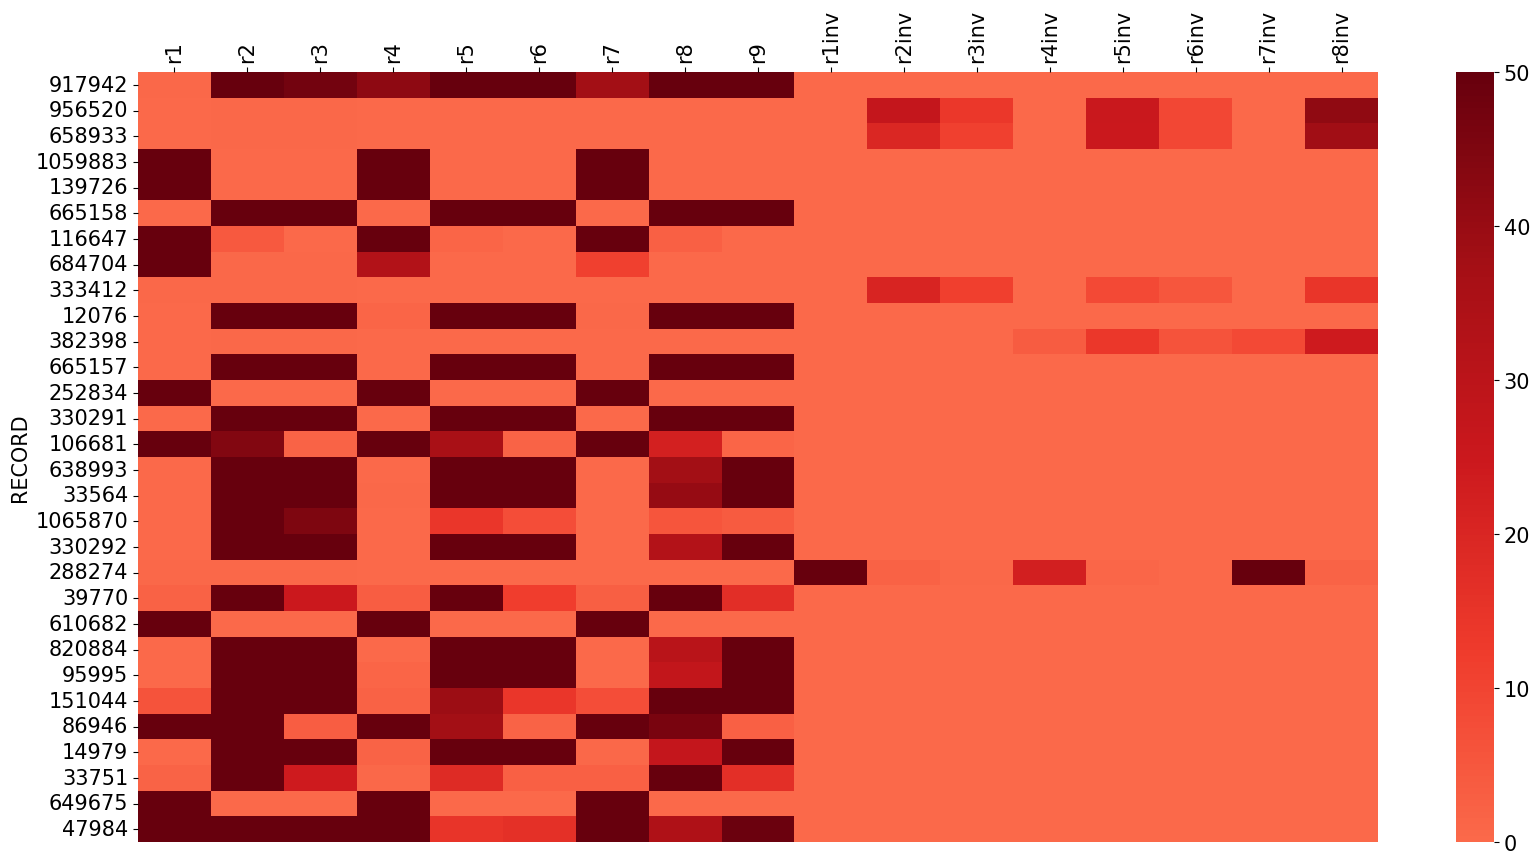

In [103]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

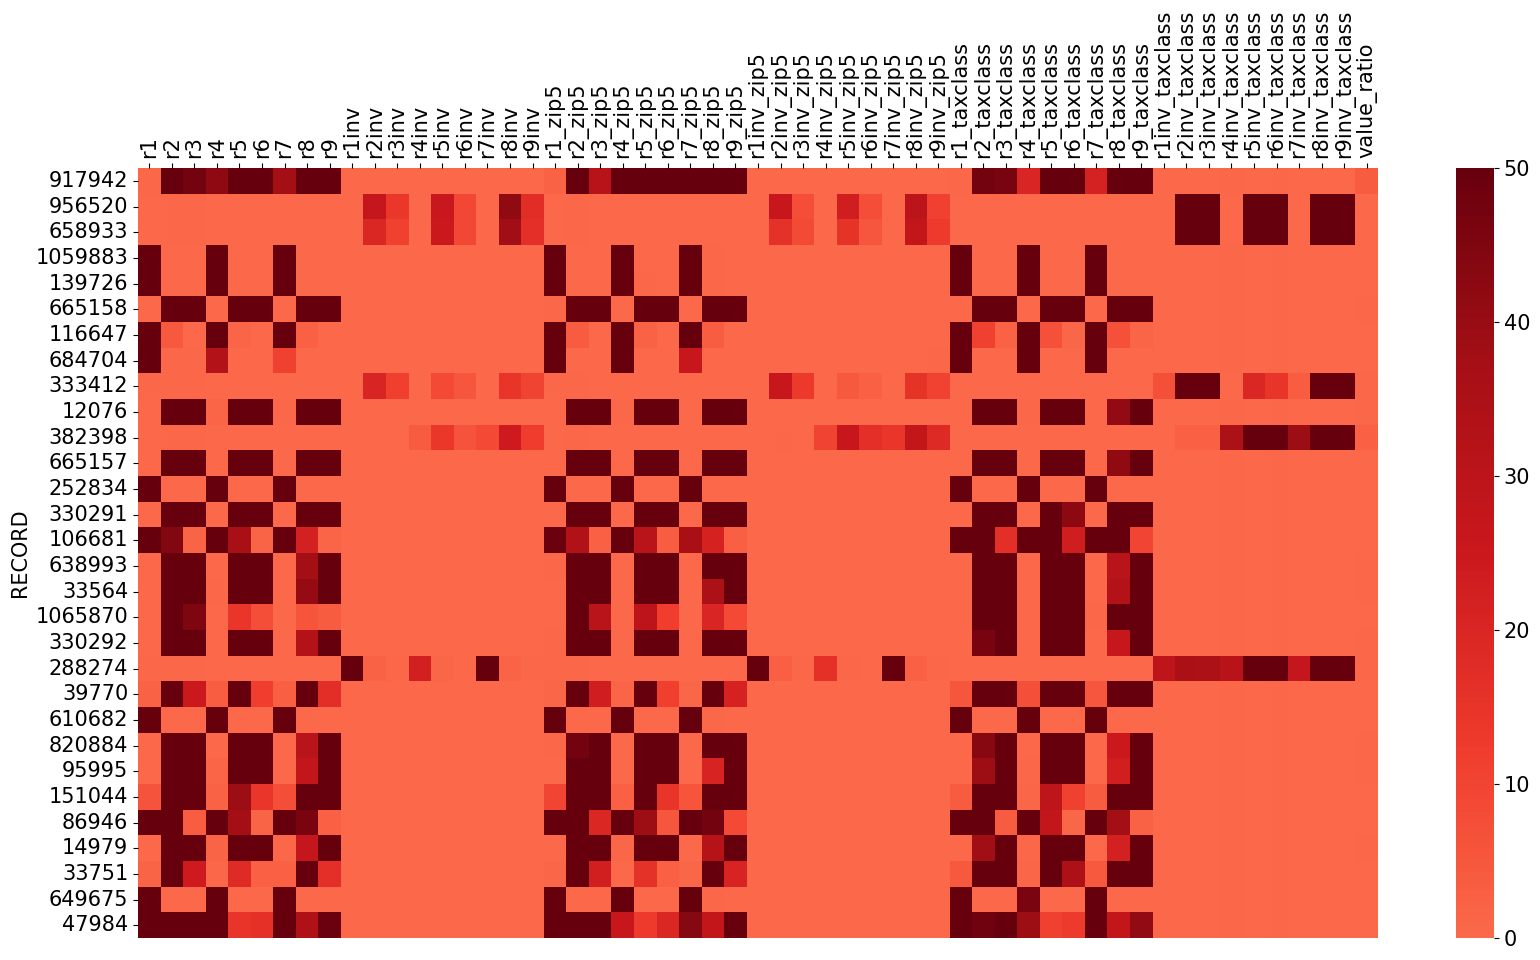

In [104]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [105]:
top_records_df = pd.DataFrame(top_records)

In [106]:
top_records_df.head()

,RECORD
0,917942
1,956520
2,658933
3,1059883
4,139726


In [107]:
import pandas as pd

# Assuming your original dataframe is called 'df'
#records_df = pd.DataFrame({'RECORD': [917942, 956520, 934793, 658933, 1054166]})

# Use the 'loc' function to filter the rows based on the record numbers
#new_df = data.loc[data['RECORD'].isin(top_records_df['RECORD'])]


In [108]:
# Use this cell if you want to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [109]:
top_records_df.head()

,RECORD
0,917942
1,956520
2,658933
3,1059883
4,139726


In [110]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [111]:
# about 4 minutes
print('Duration: ', datetime.now() - start_time)

Duration:  0:01:31.967915
